# Практическое задание 3

# Named Entity Recognition

Дата выдачи: <span style="color:red">__16 ноября 21:00__</span>.

Дедлайн: <span style="color:red">__01 декабря 22:00__</span>.

## Введение

### Постановка задачи

В этом задании вы будете решать задачу извлечения именованных сущностей (Named Entity Recognition) – одну из самых распространенных в NLP, наряду с задачей текстовой классификации.

Данная задача заключается в том, что нужно классифицировать каждое слово / токен на предмет того, является ли оно частью именованной сущности (сущность может состоять из нескольких слов / токенов) или нет.

Например, мы хотим извлечь имена и названия организаций. Тогда для текста

    Yan    Goodfellow  works  for  Google  Brain

модель должна извлечь следующую последовательность:

    B-PER  I-PER       O      O    B-ORG   I-ORG

где префиксы *B-* и *I-* означают начало и конец именованной сущности, *O* означает слово без тега. Такая префиксная система (*BIO*-разметка) введена, чтобы различать последовательные именованные сущности одного типа.
Существуют и другие типы разметок, например *BILUO*, но в рамках данного практического задания сфокусируемся имеено на *BIO*.

Решать NER задачу мы будем на датасете CoNLL-2003 с использованием рекуррентных сетей и моделей на базе архитектуры Transformer. Датасет CoNLL-2003 представлен в виде разметки **BIO**, где лейбл:
- *B-{label}* - начало сущности *{label}*;
- *I-{label}* - продолжение сущности *{label}*;
- *O* - отсутсвие сущности.

Здесь в качестве сущности *{label}* может выступать имя, географическое название или какой-то другой тип собственных имён. Подробнее с разметками можно ознакомится во вспомогательном ноутбуке.

### Библиотеки

Основные библиотеки:
 - [PyTorch](https://pytorch.org/)
 - [Transformers](https://github.com/huggingface/transformers)

### Данные

Данные лежат в архиве, который состоит из:

- *train.tsv* - обучающая выборка. В каждой строке записаны: <слово / токен>, <тэг слова / токена>

- *valid.tsv* - валидационная выборка, которую можно использовать для подбора гиперпарамеров и замеров качества. Имеет идентичную с train.tsv структуру.

- *test.tsv* - тестовая выборка, по которой оценивается итоговое качество. Имеет идентичную с train.tsv структуру.

Скачать данные можно здесь: [ссылка](https://github.com/valerapon/msu_task_3_ner)

In [1]:
!pip install numpy==1.23.5 scikit-learn==1.2.2 tensorboard==2.14.1 torch==2.1.0 tqdm==4.66.1 transformers==4.34.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import random
from collections import Counter, defaultdict, namedtuple
from typing import Tuple, List, Dict, Any

import torch
import numpy as np

from tqdm import tqdm, trange

Зафиксируем seed (значение 42) для воспроизводимости результатов (желательно делать **всегда**!):

In [3]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_global_seed(42)

Проинициализируем device (CPU / GPU) на котором будем работать (желательно **GPU**):

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!git clone https://github.com/valerapon/msu_task_3_ner.git

Cloning into 'msu_task_3_ner'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 735.47 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
!mv msu_task_3_ner/data data

In [6]:
!rm -rf msu_task_3_ner

## Часть 1. Подготовка данных (4 балла)

Первым делом нам нужно считать данные. Давайте напишем функцию, которая на вход принимает путь до одного из conll-2003 файла и возвращает два списка:
- список списков слов / токенов;
- список списков тегов, который соответствует собранному списку слов / токенов.

Также функция на вход принимает булевую переменную *lowercase*, которая задает чувствительность к регистру. Далее будем всё приводить к нижнему регистру (`lower=True`).

P.S. Стоит держать в голове, что в некоторых ситуациях верхний регистр помогает выявлять именованные сущности. Например, у вас нет мощностей, чтобы запускать сложные модели, а задачу решать нужно быстро. В этом случае эвристическое правило: "Большая буква в слове = именнованная сущность" может вам помочь. Или у вас есть огромные корпусы данных, которые позволяют сохранять исходное разнообразие слов.

**Задание. Реализуйте функцию read_conll2003.** **<font color='red'>(1 балл)</font>**

<details>
<summary> Подсказка </summary>

*Предложения разделены пустой строкой, в конце файла также пустая строка, но не забывайте про символ `\n`.*

</details>


In [6]:
def read_conll2003(
    path: str,
    lower: bool = True,
) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Prepare data in CoNNL like format.

    Args:
        path: The path to the file (str).
        lower:  Reduce text to lowercase (bool).

    Returns:
        Function returns pair (token_seq, label_seq).
        token_seq: The list of lists. Each internal list is
            a sentence converted into tokens.
        label_seq: The list of lists. All internal lists
            contain tags corresponding to tokens from token_seq.

    """

    token_seq: List[List[str]] = []
    label_seq: List[List[str]] = []

    # ### START CODE HERE ###
    current_tokens = []
    current_labels = []

    with open(path) as file:
        for line in file:
            if line in '\n':
                if current_tokens and current_labels:
                    token_seq.append(current_tokens)
                    label_seq.append(current_labels)
                current_tokens = []
                current_labels = []
            else:
                token, label = line.split()
                if lower:
                    token = token.lower()

                current_tokens.append(token)
                current_labels.append(label)

        if current_tokens and current_labels:
            token_seq.append(current_tokens)
            label_seq.append(current_labels)
    # ### END CODE HERE ###

    return token_seq, label_seq

Считаем все три файла:
- *train.tsv*
- *valid.tsv*
- *test.tsv*

In [7]:
train_token_seq, train_label_seq = read_conll2003("data/train.txt")
valid_token_seq, valid_label_seq = read_conll2003("data/valid.txt")
test_token_seq, test_label_seq = read_conll2003("data/test.txt")

Посмотрим на то, что мы получили:

In [8]:
for token, label in zip(train_token_seq[0], train_label_seq[0]):
    print(f"{token}\t{label}")

eu	B-ORG
rejects	O
german	B-MISC
call	O
to	O
boycott	O
british	B-MISC
lamb	O
.	O


In [9]:
for token, label in zip(valid_token_seq[0], valid_label_seq[0]):
    print(f"{token}\t{label}")

cricket	O
-	O
leicestershire	B-ORG
take	O
over	O
at	O
top	O
after	O
innings	O
victory	O
.	O


In [10]:
for token, label in zip(test_token_seq[0], test_label_seq[0]):
    print(f"{token}\t{label}")

soccer	O
-	O
japan	B-LOC
get	O
lucky	O
win	O
,	O
china	B-PER
in	O
surprise	O
defeat	O
.	O


In [11]:
assert len(train_token_seq) == len(train_label_seq), "Длины тренировочных token_seq и label_seq не совпадают, ошибка в функции read_conll2003"
assert len(valid_token_seq) == len(valid_label_seq), "Длины валидационных token_seq и label_seq не совпадают, ошибка в функции read_conll2003"
assert len(test_token_seq) == len(test_label_seq), "Длины тестовых token_seq и label_seq не совпадают, ошибка в функции read_conll2003"

assert train_token_seq[0] == ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'], "Ошибка в тренировочном token_seq"
assert train_label_seq[0] == ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], "Ошибка в тренировочном label_seq"

assert valid_token_seq[0] == ['cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.'], "Ошибка в валидационном token_seq"
assert valid_label_seq[0] == ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], "Ошибка в валидационном label_seq"

assert test_token_seq[0] == ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.'], "Ошибка в тестовом token_seq"
assert test_label_seq[0] == ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O'], "Ошибка в тестовом label_seq"

print("Тесты пройдены!")

Тесты пройдены!


### Подготовка словарей

Чтобы обучать нейронную сеть, мы будем использовать два отображения:
- {**token**}→{**token_idx**}: соответствие между словом / токеном и индексом строки в *embedding* матрице (начинается с 0);
- {**label**}→{**label_idx**}: соответствие между тегом и уникальным индексом (начинается с 0).

Теперь нам необходимо реализовать две функции:
- *get_token2idx*
- *get_label2idx*

которые будут возвращать соответствующие словари (*token2idx* и *label2idx*).

Словарь *token2idx* должен содержать специальные токены, которые нужно добавить самим:
- `<PAD>` - спецтокен для паддинга (отступа), так как мы собираемся обучать модели батчами. Токен `<PAD>` нужен для выравнивания предложений по длине, когда их будем помещать в один батч. Чаще всего предложения дополняются с конца;
- `<UNK>` - спецтокен для обработки слов / токенов, которых нет в словаре (актуально для инференса).

Давайте для удобства дадим токену `<PAD>` индекс `0`, а токену `<UNK>` индекс `1`.

В функцию *get_token2idx* также необходимо добавить параметр *min_count*, который будет включать только слова, превышающие определенную частоту.

Для начала посмотрим, а сколько вообще уникальных слов в обучающих данных и число их вхождений:

In [12]:
token_counter = Counter([token for sentence in train_token_seq for token in sentence])
print(*token_counter.most_common(10), sep='\n')
print(f"Количество уникальных слов в тренировочном датасете: {len(token_counter)}")
print(f"Количество слов встречающихся только один раз в тренировочном датасете: {len([token for token, cnt in token_counter.items() if cnt == 1])}")

('the', 8390)
('.', 7374)
(',', 7290)
('of', 3815)
('in', 3621)
('to', 3424)
('a', 3199)
('and', 2872)
('(', 2861)
(')', 2861)
Количество уникальных слов в тренировочном датасете: 21010
Количество слов встречающихся только один раз в тренировочном датасете: 10060


Как мы видим, у нас есть много слов, которые в обучении встречаются только один раз. Очевидно, что выучиться по ним у нас не получиться, мы только переобучимся, поэтому давайте выкинем такие слова при формировании нашего словаря, задав параметр функции `min_count=2`.

На этом этапе можно применять различные методы сокращения размера словаря, преобразовывая разные словоформы одного слова в один токен: стемминг или лемматизация. В текущей задаче мы это опустим, но в некоторых ситуациях это бывает полезно.

**Задание. Реализуйте функции get_token2idx и get_label2idx.** **<font color='red'>(1 балл)</font>**

<details>
<summary> Подсказка №1 </summary>

*Не забудьте, что у \<PAD\> индекс 0, а у \<UNK\> индекс 1.*

</details>

<details>
<summary> Подсказка №2 </summary>

*Лучше всего словари token2idx и label2idx собирать с помощью token2cnt в get_token2idx и label_list в get_label2idx соответственно.*

</details>

<details>
<summary> Подсказка №3 </summary>

*В label_list в get_label2idx лежат отсортированные по возрастанию тэги, за исключением тэга 'O' – он идет первый (индекс 0). Этот порядок нужно сохранить при индексации в label2idx.*

</details>

In [13]:
def get_token2idx(
    token_seq: List[List[str]],
    min_count: int,
) -> Dict[str, int]:
    """
    Get mapping from tokens to indices to use with Embedding layer.

    Args:
        token_seq: The list of lists. Each internal list (sentence)
            consists of tokens.
        min_count:  The minimum number of repetitions of
            a token in the corpus.

    Returns:
        Function returns mapping from token to id.
        token2idx: The mapping from token
            to id without "rare" words.

    """

    token2idx: Dict[str, int] = {}
    token2cnt = Counter([token for sentence in token_seq for token in sentence])

    # ### START CODE HERE ###
    token2idx['<PAD>'] = 0
    token2idx['<UNK>'] = 1

    last_id = 2
    token2idx.update(zip((key for key, value in token2cnt.items() if value >= min_count), range(2, len(token2cnt) + 2)))
    # ### END CODE HERE ###

    return token2idx

In [14]:
token2idx = get_token2idx(train_token_seq, min_count=2)

In [15]:
def get_label2idx(label_seq: List[List[str]]) -> Dict[str, int]:
    """
    Get mapping from labels to indices.

    Args:
        label_seq: The list of lists. Each internal list (sentence)
            consists of labels.

    Returns:
        Function returns mapping from label to id.
        label2idx: The mapping from label to id.

    """

    label2idx: Dict[str, int] = {}
    label_list = set(label for sentence in label_seq for label in sentence)
    label_list = sorted(label_list, key=lambda x: 'A' if x == 'O' else x)

    # ### START CODE HERE ###
    label2idx.update(zip(label_list, range(len(label_list))))
    # ### END CODE HERE ###

    return label2idx

In [16]:
label2idx = get_label2idx(train_label_seq)

Посмотрим на то, что мы получили:

In [17]:
for token, idx in list(token2idx.items())[:10]:
    print(f"{token}\t{idx}")

<PAD>	0
<UNK>	1
eu	2
german	3
call	4
to	5
boycott	6
british	7
lamb	8
.	9


In [18]:
for label, idx in label2idx.items():
    print(f"{label}\t{idx}")

O	0
B-LOC	1
B-MISC	2
B-ORG	3
B-PER	4
I-LOC	5
I-MISC	6
I-ORG	7
I-PER	8


In [19]:
assert len(get_token2idx(train_token_seq, min_count=1)) == 21012, "Ошибка в длине словаря, скорее всего неверно реализован min_count"
assert len(token2idx) == 10952, "Неправильная длина token2idx, скорее всего неверно реализован min_count"
assert len(label2idx) == 9, "Неправильная длина label2idx"

assert list(token2idx.items())[:10] == [('<PAD>', 0), ('<UNK>', 1), ('eu', 2), ('german', 3), ('call', 4), ('to', 5), ('boycott', 6), ('british', 7), ('lamb', 8), ('.', 9)], "Неправильно сформированный token2idx"
assert label2idx == {'O': 0, 'B-LOC': 1, 'B-MISC': 2, 'B-ORG': 3, 'B-PER': 4, 'I-LOC': 5, 'I-MISC': 6, 'I-ORG': 7, 'I-PER': 8}, "Неправильно сформированный label2idx"

print("Тесты пройдены!")

Тесты пройдены!


### Подготовка датасета и загрузчика

Обычно нейронные сети обучаются батчами. Это означает, что каждое обновление весов нейронной сети происходит на основе нескольких последовательностей. Технической деталью является необходимость дополнить все последовательности внутри батча до одной длины.

Из предыдущего практического задания вы должны знать о `Dataset`'е (`torch.utils.data.Dataset`) – структура данных, которая хранит и может по индексу отдавать данные для обучения. Датасет должен наследоваться от стандартного PyTorch класса Dataset и переопределять методы `__len__` и `__getitem__`.

Метод `__getitem__` должен возвращать индексированную последовательность и её теги.

**Не забудьте** про `<UNK>` спецтокен для неизвестных слов!
    
Давайте напишем кастомный датасет под нашу задачу, который на вход (метод `__init__`) будет принимать:
- *token_seq* – список списков слов / токенов;
- *label_seq* – список списков тегов;
- *token2idx* – отображение токена в индекс;
- *label2idx* – отображение тега в индекс.

и возвращать из метода `__getitem__` два Int64 тензора (`torch.LongTensor`) из индексов слов / токенов в сэмпле и индексов соответвующих тегов:

**Задание. Реализуйте класс датасета NERDataset.** **<font color='red'>(1 балл)</font>**

<details>
<summary> Подсказка </summary>

*Для понимания, зачем нужен вообще этот Dataset. У нас по факту есть "сырые" последовательности token_seq и label_seq, которые по индексу будут возвращать и нужный набор токенов, и соответствующий список тегов. Но для обучения это неудобно, потому что каждый раз нам необходимо конвертировать токены и теги в индексы. Инструмент Dataset нужен для того, чтобы, не задумываясь, извлекать элементы в нужном формате автоматически, как из массива.*

</details>

In [20]:
class NERDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for NER.
    """

    def __init__(
        self,
        token_seq: List[List[str]],
        label_seq: List[List[str]],
        token2idx: Dict[str, int],
        label2idx: Dict[str, int],
    ) -> None:
        """
        Constructor of NERDataset class.

        Args:
            token_seq: The list of lists. Each internal list (sentence)
                consists of tokens.
            label_seq: The list of lists. Each internal list (sentence)
                consists of labels.
            token2idx: The mapping from token to id.
            label2idx: The mapping from label to id.

        Returns:
            None

        """
        self.token2idx = token2idx
        self.label2idx = label2idx

        self.token_seq = [self.process_tokens(tokens, token2idx) for tokens in token_seq]
        self.label_seq = [self.process_labels(labels, label2idx) for labels in label_seq]

    def __len__(self) -> int:
        """
        Get dataset size.

        Args:

        Returns:
            The method returns the length of the dataset.

        """
        return len(self.token_seq)

    def __getitem__(
        self,
        idx: int,
    ) -> Tuple[torch.LongTensor, torch.LongTensor]:
        """
        Get an element from a dataset by index.
        Recomendation: use LongTensor.

        Args:
            idx: Index of element (int).

        Returns:
            The method returns required element. From
            self.token_seq and self.label_seq.

        """
        token_ids = None
        label_ids = None

        # ### START CODE HERE ###
        token_ids = torch.LongTensor(self.token_seq[idx])
        label_ids = torch.LongTensor(self.label_seq[idx])
        # ### END CODE HERE ###
        return token_ids, label_ids

    @staticmethod
    def process_tokens(
        tokens: List[str],
        token2idx: Dict[str, int],
        unk: str = "<UNK>",
    ) -> List[int]:
        """
        Transform list of tokens into list of tokens' indices.

        Args:
            tokens: The list (sentence) of tokens.
            token2idx: The mapping from token to id.
            unk: Name of <UNK> token (str).

        Returns:
            token_ids: The list of indices. Each index
                corresponds to a token from the tokens.

        """
        token_ids: List[int] = []

        # ### START CODE HERE ###
        token_ids.extend([token2idx[token if token in token2idx else unk] for token in tokens])
        # ### END CODE HERE ###
        return token_ids

    @staticmethod
    def process_labels(
        labels: List[str],
        label2idx: Dict[str, int],
    ) -> List[int]:
        """
        Transform list of labels into list of labels' indices.

        Args:
            labels: The list of labels.
            label2idx: The mapping from label to id.

        Returns:
            label_ids: The list of indices. Each index
                corresponds to a label from the labels.

        """
        label_ids = List[int]
        label_ids = []

        # ### START CODE HERE ###
        label_ids.extend([label2idx[label] for label in labels])
        # ### END CODE HERE ###
        return label_ids

Создадим три датасета:
- *train_dataset*
- *valid_dataset*
- *test_dataset*

In [21]:
train_dataset = NERDataset(
    token_seq=train_token_seq,
    label_seq=train_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
valid_dataset = NERDataset(
    token_seq=valid_token_seq,
    label_seq=valid_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
test_dataset = NERDataset(
    token_seq=test_token_seq,
    label_seq=test_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)

Посмотрим на то, что мы получили:

In [22]:
train_dataset[0]

(tensor([2, 1, 3, 4, 5, 6, 7, 8, 9]), tensor([3, 0, 2, 0, 0, 0, 2, 0, 0]))

In [23]:
valid_dataset[0]

(tensor([1737,  571, 1777,  197,  687,  145,  349,  111, 1819, 1558,    9]),
 tensor([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]))

In [24]:
test_dataset[0]

(tensor([1516,  571, 1434, 1729, 4893, 2014,   67,  310,  215, 3157, 3139,    9]),
 tensor([0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0]))

In [25]:
assert len(train_dataset) == 14986, "Неправильная длина train_dataset"
assert len(valid_dataset) == 3465, "Неправильная длина valid_dataset"
assert len(test_dataset) == 3683, "Неправильная длина test_dataset"

assert torch.equal(train_dataset[0][0], torch.tensor([2,1,3,4,5,6,7,8,9])), "Неправильно сформированный train_dataset"
assert torch.equal(train_dataset[0][1], torch.tensor([3,0,2,0,0,0,2,0,0])), "Неправильно сформированный train_dataset"

assert torch.equal(valid_dataset[0][0], torch.tensor([1737,571,1777,197,687,145,349,111,1819,1558,9])), "Неправильно сформированный valid_dataset"
assert torch.equal(valid_dataset[0][1], torch.tensor([0,0,3,0,0,0,0,0,0,0,0])), "Неправильно сформированный valid_dataset"

assert torch.equal(test_dataset[0][0], torch.tensor([1516,571,1434,1729,4893,2014,67,310,215,3157,3139,9])), "Неправильно сформированный test_dataset"
assert torch.equal(test_dataset[0][1], torch.tensor([0,0,1,0,0,0,0,4,0,0,0,0])), "Неправильно сформированный test_dataset"

print("Тесты пройдены!")

Тесты пройдены!


Для того, чтобы дополнять последовательности паддингом, будем использовать параметр `collate_fn` класса `DataLoader`.

Принимая последовательность пар тензоров для предложений и тегов, необходимо дополнить все последовательности до последовательности максимальной длины в батче.

Используйте для дополнения спецтокен `<PAD>` для последовательностей слов / токенов и -1 для последовательностей тегов.

**hint**: удобно использовать метод **torch.nn.utils.rnn**. Обратите особое внимание на параметр *batch_first*

`Collator` можно реализовать двумя способами:
- класс с методом `__call__`
- функцию

Мы пойдем первым путем.

Инициализировать экземпляр класса `Collator` (метод `__init__`) с помощью двух параметров:
- id `<PAD>` спецтокена для последовательностей слов / токенов
- id `<PAD>` спецтокена для последовательностей тегов (значение -1)

Метод `__call__` на вход принимает батч, а именно список кортежей того, что нам возвращается из датасета. В нашем случае это список кортежей двух int64 тензоров - `List[Tuple[torch.LongTensor, torch.LongTensor]]`.

На выходе мы хотим получить два тензора:
- западденные индексы слов / токенов
- западденные индексы тегов
    
P.S. `<PAD>` значение нужно для того, чтобы при подсчете лосса легко отличать западдированные токены от других. Можно использовать параметр *ignore_index* при инициализации лосса.

**Задание. Реализуйте класс коллатора NERCollator.** **<font color='red'>(1 балл)</font>**

<details>
<summary> Пояснение </summary>

*Чтобы ускорить взаимодействие с нейронными сетями, им на вход подаются не одна пара (объект, ответ), а несколько. Они объединяются в одну связку, которую называют батч. В нашем случае объекты -- это последовательности слов, которые имеют разную длину. Мы не можем в одном pytorch.tensor (или numpy.array) хранить последовательности разных длин, поэтому требуется их привести к одной (например, к длине максимальной последовательности), чем коллатор и занимается.*

</details>

In [26]:
class NERCollator:
    """
    Collator that handles variable-size sentences.
    """

    def __init__(
        self,
        token_padding_value: int,
        label_padding_value: int,
    ):
        self.token_padding_value = token_padding_value
        self.label_padding_value = label_padding_value

    def __call__(
        self,
        batch: List[Tuple[torch.LongTensor, torch.LongTensor]],
    ) -> Tuple[torch.LongTensor, torch.LongTensor]:
        """
        The method appends <PAD> token id to tensor with
        token ids and -1 to tensor with labels.
        The function torch.nn.utils.rnn.pad_sequence is useful for padding. Link:
        https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

        Args:
            batch: The list of tuples. Each tuple conists of the tensor with token ids and
                the tensor with label ids.

        Returns:
            (tokens, labels): a pair of tensors with sizes: (batch_size, sentence_len).

        """
        tokens, labels = zip(*batch)

        # ### START CODE HERE ###
        tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=self.token_padding_value)
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=self.label_padding_value)
        # ### END CODE HERE ###

        return tokens, labels

In [27]:
collator = NERCollator(
    token_padding_value=token2idx["<PAD>"],
    label_padding_value=-1,
)

Теперь всё готово, чтобы задать `DataLoader`'ы:

In [28]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collator,
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)

Посмотрим на то, что мы получили:

In [29]:
tokens, labels = next(iter(train_dataloader))

tokens = tokens.to(device)
labels = labels.to(device)

In [30]:
tokens

tensor([[7796, 1162, 2553, 7237, 1342,    0,    0,    0,    0,    0],
        [ 125, 1167,    1,   67, 1349,  489, 1215, 1364, 1365, 1366]],
       device='cuda:0')

In [31]:
labels

tensor([[ 3,  0,  3,  7,  0, -1, -1, -1, -1, -1],
        [ 0,  4,  8,  0,  1,  0,  0,  0,  0,  0]], device='cuda:0')

In [32]:
train_tokens, train_labels = next(iter(
    torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(train_tokens, torch.tensor([[ 2,  1,  3,  4,  5,  6,  7,  8,  9], [10, 11,  0,  0,  0,  0,  0,  0,  0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(train_labels, torch.tensor([[ 3,  0,  2,  0,  0,  0,  2,  0,  0], [ 4,  8, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

valid_tokens, valid_labels = next(iter(
    torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(valid_tokens, torch.tensor([[ 1737,   571,  1777,   197,   687,   145,   349,   111,  1819,  1558, 9], [  248, 10679,     0,     0,     0,     0,     0,     0,     0,     0,    0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(valid_labels, torch.tensor([[ 0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0], [ 1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

test_tokens, test_labels = next(iter(
    torch.utils.data.DataLoader(
        test_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(test_tokens, torch.tensor([[1516,  571, 1434, 1729, 4893, 2014,   67,  310,  215, 3157, 3139,    9], [   1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(test_labels, torch.tensor([[ 0,  0,  1,  0,  0,  0,  0,  4,  0,  0,  0,  0], [ 4,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

print("Тесты пройдены!")

Тесты пройдены!


## Часть 2. BiLSTM-теггер (6 баллов)

Определите архитектуру сети, используя библиотеку PyTorch.

Ваша архитектура в этом пункте должна соответствовать стандартному теггеру:
* Embedding слой на входе
* LSTM (однонаправленный или двунаправленный) слой для обработки последовательности
* Dropout (заданный отдельно или встроенный в LSTM) для уменьшения переобучения
* Linear слой на выходе

Для обучения сети используйте поэлементную кросс-энтропийную функцию потерь.

**Обратите внимание**, что `<PAD>` токены не должны учавствовать в подсчёте функции потерь. В качестве оптимизатора рекомендуется использовать Adam. Для получения значений предсказаний по выходам модели используйте функцию `argmax`.

**Задание. Реализуйте класс модели BiLSTM.** **<font color='red'>(2 балл)</font>**

<details>
<summary> Подсказка №1 </summary>

*Помните, что следуется явно указывать параметр `batch_first=True`.*

</details>

<details>
<summary> Подсказка №2 </summary>

*Число входных признаков `in_features` в линейном слое зависим от типа LSTM: однонаправленная или двунаправленая. В первом случае выходом i-го блока является скрытое состояние $h_i$, которое имеет размер `hidden_size`, и соответственно, `in_features=hidden_size`. А в случае двунаправленной сети вход представим в виде конкатенации скрытых состояний из разных уровней сети: $[h_i^1, h_i^2]$, здесь `in_features=2 * hidden_size`.*

</details>

<details>
<summary> Рекомендация </summary>

*Обратите внимание на метод `BiLSTM.forward`, реализовывать самостоятельно его не нужно. В нем используется функция `pack_padded_sequence` и обратная ей `pad_packed_sequence`. Это удобный инструмент для фильтрации входных последовательностей от токенов отступа.*

</details>

In [33]:
from torch.nn import Embedding, LSTM, Linear


class BiLSTM(torch.nn.Module):
    """
    Bidirectional LSTM architecture.
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        bidirectional: bool,
        n_classes: int,
        token_padding_value: int,
        max_norm: float,
    ) -> None:
        """
        BiLSTM class constructor. The method contains a description
        of the network layers and their parameters.

        Args:
            num_embeddings: The number of unique words (tokens) in the
                dictionary, or the size of the dictionary (int)
            embedding_dim:  Embedding word size (size)
            hidden_size: The size of the hidden state (h_n) in the LSTM network (int)
            num_layers: The total number of blocks in an LSTM network (int)
            dropout: dropout parameter in LSTM layers (float)
            bidirectional: a parameter that controls whether the LSTM is
                unidirectional (one direction) or bidirectional (bool)
            n_classes: the number of classes in a problem being solved (int)

        Returns:
            None

        Tips:
            - do not forget to specify batch_first=True
            - control the size of the in_features in linear
                layer depending on the value of 'bidirectional'
        """
        super().__init__()

        self.token_padding_value = token_padding_value
        self.embedding = Embedding(num_embeddings, embedding_dim) # Embedding layer
        self.rnn = LSTM(input_size=embedding_dim,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=bidirectional) # LSTM layer
        self.head = Linear(hidden_size * (int(bidirectional) + 1), n_classes) # Linear layer


    def forward(self, tokens: torch.LongTensor) -> torch.Tensor:
        """
        Applying neural network layers to input 'tokens'.

        Args:
            tokens: the input tensor with tokens ids (batch_size, sequence_len)

        Returns:
            logits: the scores issued by the model (batch_size, num_classes, sequence_len)
        """
        embed = self.embedding(tokens)

        # Используем специальную функцию pack_padded_sequence для того, чтобы получить
        # структуру PackedSequence, которая не учитывать паддинг при проходе rnn.
        # lengths -- длины исходных исходных последовательностей в батче,
        # без учёта сдвига
        lengths = (tokens != self.token_padding_value).sum(dim=1).detach().cpu()
        packed_embed = torch.nn.utils.rnn.pack_padded_sequence(
            input=embed,
            lengths=lengths,
            batch_first=True,
            enforce_sorted=False,
        )

        # Используем специальную функцию pad_packed_sequence для того, чтобы получить
        # тензор из PackedSequence. Операция является обратной к pack_padded_sequence
        packed_rnn_output, _ = self.rnn(packed_embed)
        rnn_output, _ = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=packed_rnn_output,
            batch_first=True
        )

        logits = self.head(rnn_output)
        logits = logits.transpose(1, 2)
        return logits

In [34]:
model = BiLSTM(
    num_embeddings=len(token2idx),
    embedding_dim=300,
    hidden_size=256,
    num_layers=1,
    dropout=0.0,
    bidirectional=True,
    n_classes=len(label2idx),
    token_padding_value=token2idx["<PAD>"],
    max_norm=None
).to(device)

In [35]:
model

BiLSTM(
  (embedding): Embedding(10952, 300)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (head): Linear(in_features=512, out_features=9, bias=True)
)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

In [37]:
outputs = model(tokens)

In [38]:
assert outputs.shape == torch.Size([2, 9, 10])
assert 2 < criterion(outputs, labels) < 3

print("Тесты пройдены!")

Тесты пройдены!


### Эксперименты

Проведите эксперименты на данных. Настраивайте параметры по валидационной выборке, не используя тестовую. Ваше цель — настроить сеть так, чтобы качество модели по F1-macro мере на валидационной и тестовой выборках было не меньше **0.76**.

Сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

In [38]:
# Создадим SummaryWriter для эксперимента с BiLSTMModel
# для отслеживания процесса обучения нейронной сети

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f"logs/BiLSTMModel")

2024-11-29 22:59:29.721659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732921169.739053 3525787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732921169.744470 3525787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 22:59:29.761837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Задание. Реализуйте функцию подсчета метрик compute_metrics.** **<font color='red'>(1 балл)</font>**

<details>
<summary> Подсказка №1 </summary>

*Модель выдает логиты, или скоры, для каждого токена по каждому классу. Для подсчета метрик нужно, подобно максимизации вероятности, каждому токену входной последовательности определять класс с максимальный скором. Пример: токен `X` получил скоры (выход модели) для четырех классов `[0.5, 10.2, -13,9, 5,5]` соответственно, следовательно, нам необходимо определять для токена `X` класс № 1 (нумерация с нуля, `score=10.2`) как наиболее "вероятный".*

</details>

<details>
<summary> Подсказка №2 </summary>

*Входные тензоры необходимо перевести на CPU (если они на GPU), конвертировать в numpy-массив и для простоты вытянуть в вектор с помощью функции `flatten`.*

</details>

<details>
<summary> Подсказка №3 </summary>

*Не забудьте отфильтровать `<PAD>` токен.*

</details>

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def compute_metrics(
    outputs: torch.Tensor,
    labels: torch.LongTensor,
) -> Dict[str, float]:
    """
    Compute NER metrics.

    Args:
        outputs: the model outputs (batch_size, num_classes, sequence_len)
        labels: the correct classes (batch_size, sequence_len)

    Returns:
        metrics: mapping metric names to their corresponding values
    """

    metrics = {}
    y_true = labels.detach().cpu().numpy()
    y_pred = torch.argmax(outputs.detach(), dim=1).cpu().numpy()

    # ### START CODE HERE ###
    batch_size, sequence_len = y_true.shape
    y_pred = y_pred[y_true != -1]
    y_true = y_true[y_true != -1]

    # ### END CODE HERE ###

    metrics['accuracy'] = accuracy_score(
        y_true=y_true,
        y_pred=y_pred,
    )

    for metric_func in [precision_score, recall_score, f1_score]:
        metric_name = metric_func.__name__.split('_')[0]
        for average_type in ["micro", "macro", "weighted"]:
            metrics[metric_name + '_' + average_type] = metric_func(
                y_true=y_true,
                y_pred=y_pred,
                average=average_type,
                zero_division=0,
            )

    return metrics

In [40]:
compute_metrics(
    outputs=outputs,
    labels=labels,
)

{'accuracy': 0.06666666666666667,
 'precision_micro': 0.06666666666666667,
 'precision_macro': 0.0625,
 'precision_weighted': 0.3,
 'recall_micro': 0.06666666666666667,
 'recall_macro': 0.013888888888888888,
 'recall_weighted': 0.06666666666666667,
 'f1_micro': 0.06666666666666667,
 'f1_macro': 0.022727272727272728,
 'f1_weighted': 0.1090909090909091}

**Задание. Реализуйте функции обучения и тестирования train_epoch и evaluate_epoch.** **<font color='red'>(2 балла)</font>**

<details>
<summary> Подсказка №1 </summary>

*Почти всегда шаг обучения модели остается неизменным. Нужно выполнить последовательность действий: обнулить градиент, получить выходы модели, посчитать лосс, посчитать новые градиенты через `.backward()`, сделать шаг оптимизатора.*

</details>

<details>
<summary> Подсказка №2 </summary>

*При evaluate-этапе никакие градиенты не вычисляются, потому нет необходимости ни их в обнулении, ни в оптимизации по ним.*

</details>

<details>
<summary> Пояснение </summary>

*В PyTorch градиенты аккумулируются, их нужно сбрасывать через `optimizer.zero_grad()` перед каждой новой итерацией, чтобы исключить влияние градиента с предыдущих итераций на шаг текущего.*

</details>

In [ ]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
    model_type: str,
) -> None:
    """
    One training cycle (loop).

    Args:
        model: BiLSTM model
        dataloader: Dataloader with train data
        optimizer: an algorithm for model optimization
        criterion: the loss function
        writer: a tool for logging the learning process
        device: the device on which the model will work
        epoch: the total number of epochs

    Returns:
        None
    """

    model.train()

    epoch_loss = []
    batch_metrics_list = defaultdict(list)

    for i, (tokens, labels) in tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc="loop over train batches",
    ):

        tokens, labels = tokens.to(device), labels.to(device)

        outputs = None
        loss = None

        if model_type == 'BiLSTM':
            # ### START CODE HERE ###
            optimizer.zero_grad()
            outputs = model(tokens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # ### END CODE HERE ###
        elif model_type == 'Transformer':
            # ### START CODE HERE ###
            # Реализуйте этот фрагмент, когда будете проводить эксперименты
            # с трансформером в третьей части задания, а пока можете пропусить.
            optimizer.zero_grad()
            loss = criterion(model(**tokens)["logits"].transpose(1, 2), labels)
            loss.backward()
            optimizer.step()

            # ### END CODE HERE ###
        else:
            raise ValueError('Use \'BiLSTM\' or \'Transformer\' model_type.')

        epoch_loss.append(loss.item())
        writer.add_scalar(
            tag="batch loss / train",
            scalar_value=loss.item(),
            global_step=epoch * len(dataloader) + i,
        )

        with torch.no_grad():
            model.eval()
            if model_type == 'BiLSTM':
                outputs_inference = model(tokens)
            elif model_type == 'Transformer':
                outputs_inference = model(**tokens)["logits"].transpose(1, 2)
            else:
                raise ValueError('Use \'BiLSTM\' or \'Transformer\' model_type.')
            model.train()

        batch_metrics = compute_metrics(
            outputs=outputs_inference,
            labels=labels,
        )

        for metric_name, metric_value in batch_metrics.items():
            batch_metrics_list[metric_name].append(metric_value)
            writer.add_scalar(
                tag=f"batch {metric_name} / train",
                scalar_value=metric_value,
                global_step=epoch * len(dataloader) + i,
            )

    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    writer.add_scalar(
        tag="loss / train",
        scalar_value=avg_loss,
        global_step=epoch,
    )

    for metric_name, metric_value_list in batch_metrics_list.items():
        metric_value = np.mean(metric_value_list)
        print(f"Train {metric_name}: {metric_value}\n")
        writer.add_scalar(
            tag=f"{metric_name} / train",
            scalar_value=metric_value,
            global_step=epoch,
        )

In [ ]:
def evaluate_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
    model_type: str,
) -> None:
    """
    One evaluation cycle (loop).

    Args:
        model: BiLSTM model
        dataloader: Dataloader with data for evaluation
        criterion: a loss function
        writer: a tool for logging the learning process
        device: the device on which the model will work
        epoch: the total number of epochs

    Returns:
        None
    """

    model.eval()

    epoch_loss = []
    batch_metrics_list = defaultdict(list)

    with torch.no_grad():

        for i, (tokens, labels) in tqdm(
            enumerate(dataloader),
            total=len(dataloader),
            desc="loop over test batches",
        ):

            tokens, labels = tokens.to(device), labels.to(device)

            if model_type == 'BiLSTM':
                # ### START CODE HERE ###
                outputs = model(tokens)
                loss = criterion(outputs, labels)
                # ### END CODE HERE ###
            elif model_type == 'Transformer':
                # ### START CODE HERE ###
                # Реализуйте этот фрагмент, когда будете проводить эксперименты
                # с трансформером в третьей части задания, а пока можете пропусить.
                outputs = model(**tokens)["logits"].transpose(1, 2)
                loss = criterion(outputs, labels)
                # ### END CODE HERE ###
            else:
                raise ValueError('Use \'BiLSTM\' or \'Transformer\' model_type.')

            epoch_loss.append(loss.item())
            writer.add_scalar(
                tag="batch loss / test",
                scalar_value=loss.item(),
                global_step=epoch * len(dataloader) + i,
            )

            batch_metrics = compute_metrics(
                outputs=outputs,
                labels=labels,
            )

            for metric_name, metric_value in batch_metrics.items():
                batch_metrics_list[metric_name].append(metric_value)
                writer.add_scalar(
                    tag=f"batch {metric_name} / test",
                    scalar_value=metric_value,
                    global_step=epoch * len(dataloader) + i,
                )

        avg_loss = np.mean(epoch_loss)
        print(f"Test loss:  {avg_loss}\n")
        writer.add_scalar(
            tag="loss / test",
            scalar_value=avg_loss,
            global_step=epoch,
        )

        for metric_name, metric_value_list in batch_metrics_list.items():
            metric_value = np.mean(metric_value_list)
            print(f"Test {metric_name}: {metric_value}\n")
            writer.add_scalar(
                tag=f"{metric_name} / test",
                scalar_value=np.mean(metric_value),
                global_step=epoch,
            )

In [ ]:
def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    model_type: str,
) -> None:
    """
    Training loop.

    Args:
        n_epochs: the total number of epochs in training
        model: BiLSTM model
        train_dataloader:  Dataloader with train data
        valid_dataloader: Dataloader with data for evaluation
        optimizer: an algorithm for model optimization
        criterion: a loss function
        writer: a tool for logging the learning process
        device: the device on which the model will work

    Returns:
        None
    """

    for epoch in range(n_epochs):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")

        train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
            model_type=model_type,
        )
        evaluate_epoch(
            model=model,
            dataloader=valid_dataloader,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
            model_type=model_type,
        )

**Задание. Проведите эксперименты.** **<font color='red'>(2 балла)</font>**

Настало время собрать все воедино. В этом блоке предлагается подбирать разные параметры, чтобы достичь качества F1-macro на тестовой и валидационной выборках не менее **0.76**.

Будем задействовать ранее определенные `test_dataloader`, `valid_dataloader`, `criretion`. Настраивайте параметры на валидационной выборке так, чтобы получить требуемое качество. Основные из них:
- `n_epoch` -- число эпох обучения, рекомендуется выбирать от 5 до 20;
- `embedding_dim` -- размерность эмбеддингов, рекомендуем выбирать от 8 до 526;
- `hidden_size` -- размерность скрытого состояния, от 8 до 1024;
- `batch_size` -- размер обучающий батчей, от 8 до 128;
- `dropout` -- параметр регуляризатора dropout, от 0 до 0.7;
- `max_norm` -- максимальное органичение на норму эмбеддингов, 1.0 или `None`;
- `lr` -- шаг оптимизатора, от 1e-3 до 1e-7.

На практике используют еще более широкий набор регулировок, которые в положительную сторону влияют на качество. В текущем задании они не используются, но стоит знать, что:

- в процессе обучения используют `gradient clipping`, чтобы контролировать норму градиентов. Величина должна быть согласована с `max_norm`, если такая используется;
- изменение `lr` в процессе обучения, например, уменьшение с каждой эпохой. В трансформерах это отдельная проблема, которая при неправильном выборе `lr` приводит к серьезному переобучению. Типичной практикой является использование планировщиков `lr`: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate;
- иногда выбор другого оптимизатора позволяет поднять качество: https://pytorch.org/docs/stable/optim.html#algorithms;
- встаивают дополнительные регуляризационные блоки и регуляризационные механизмы, например, L2-норму.

<details>
<summary> Подсказка №1 </summary>

*Следите за лоссом и метриками. Если в течение первых пяти эпохах нет роста качества, то скорее всего что-то не так.*

</details>

<details>
<summary> Подсказка №2 </summary>

*Подсказка 2: попробуйте начать с параметров `embedding_dim=300` и `hidden_size=256`, `dropout=0.0`*

</details>

In [ ]:
def fit_predict(model, model_type, param_name=None, param_value=None, batch_size=4):
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      collate_fn=collator)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 if model_type=='BiLSTM' else 1e-5)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

    train(n_epochs=5, model=model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=optimizer, criterion=criterion,
          writer=writer, device=device, model_type=model_type)

    print('---'*20, 'Test results', '---'*20, sep='')

    evaluate_epoch(
        model=model,
        dataloader=test_dataloader,
        criterion=criterion,
        writer=writer,
        device=device,
        epoch=1,
        model_type=model_type
    )

In [ ]:
params = {
    'num_embeddings': len(token2idx),
    'embedding_dim': 300,
    'hidden_size': 256,
    'num_layers': 1,
    'dropout': 0.0,
    'bidirectional': True,
    'n_classes': len(label2idx),
    'token_padding_value': token2idx['<PAD>'],
    'max_norm': None
}

In [ ]:
model = BiLSTM(**params).to(device)
fit_predict(model,'BiLSTM')

Epoch [1 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:05<00:00, 57.60it/s]


Train loss: 0.5531613765374395

Train accuracy: 0.8575914551607134

Train precision_micro: 0.8575914551607134

Train precision_macro: 0.40144369762379717

Train precision_weighted: 0.781842406134977

Train recall_micro: 0.8575914551607134

Train recall_macro: 0.37763783785213634

Train recall_weighted: 0.8575914551607134

Train f1_micro: 0.8575914551607134

Train f1_macro: 0.37466173314991036

Train f1_weighted: 0.8099396292881087



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 79.98it/s]


Test loss:  0.4021027204994526

Test accuracy: 0.8842323194873712

Test precision_micro: 0.8842323194873712

Test precision_macro: 0.6816313526600031

Test precision_weighted: 0.8356860409909728

Test recall_micro: 0.8842323194873712

Test recall_macro: 0.6962576438259681

Test recall_weighted: 0.8842323194873712

Test f1_micro: 0.8842323194873712

Test f1_macro: 0.6804805541523019

Test f1_weighted: 0.8519074509765772

Epoch [2 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:05<00:00, 57.21it/s]


Train loss: 0.2797389128420642

Train accuracy: 0.9217421548967838

Train precision_micro: 0.9217421548967838

Train precision_macro: 0.6863150747166081

Train precision_weighted: 0.9025448423769925

Train recall_micro: 0.9217421548967838

Train recall_macro: 0.6381758863260839

Train recall_weighted: 0.9217421548967838

Train f1_micro: 0.9217421548967838

Train f1_macro: 0.642960902756515

Train f1_weighted: 0.9051462534804974



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 80.29it/s]


Test loss:  0.28142973682495415

Test accuracy: 0.9234899843743043

Test precision_micro: 0.9234899843743043

Test precision_macro: 0.7834314773738165

Test precision_weighted: 0.9082934749456844

Test recall_micro: 0.9234899843743043

Test recall_macro: 0.7870710354537318

Test recall_weighted: 0.9234899843743043

Test f1_micro: 0.9234899843743043

Test f1_macro: 0.7783126887146337

Test f1_weighted: 0.9106887616403497

Epoch [3 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:05<00:00, 57.27it/s]


Train loss: 0.18361789514123

Train accuracy: 0.9492416276270259

Train precision_micro: 0.9492416276270259

Train precision_macro: 0.7929108740523316

Train precision_weighted: 0.9420642478061002

Train recall_micro: 0.9492416276270259

Train recall_macro: 0.7563421010443255

Train recall_weighted: 0.9492416276270259

Train f1_micro: 0.9492416276270259

Train f1_macro: 0.7598638184612505

Train f1_weighted: 0.9409148241160341



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 80.00it/s]


Test loss:  0.22475663834462667

Test accuracy: 0.9370533223478356

Test precision_micro: 0.9370533223478356

Test precision_macro: 0.8171896981061051

Test precision_weighted: 0.9229625060754083

Test recall_micro: 0.9370533223478356

Test recall_macro: 0.8175212354518312

Test recall_weighted: 0.9370533223478356

Test f1_micro: 0.9370533223478356

Test f1_macro: 0.8112243099914741

Test f1_weighted: 0.9255800107824947

Epoch [4 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:05<00:00, 57.25it/s]


Train loss: 0.12626651764832675

Train accuracy: 0.9663459676081038

Train precision_micro: 0.9663459676081038

Train precision_macro: 0.8563458957358951

Train precision_weighted: 0.9636478704810568

Train recall_micro: 0.9663459676081038

Train recall_macro: 0.8310291273409874

Train recall_weighted: 0.9663459676081038

Train f1_micro: 0.9663459676081038

Train f1_macro: 0.8330390960730097

Train f1_weighted: 0.9618534944882461



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 80.12it/s]


Test loss:  0.21369060044226001

Test accuracy: 0.9414962408450127

Test precision_micro: 0.9414962408450127

Test precision_macro: 0.8323155204375059

Test precision_weighted: 0.9260102188546603

Test recall_micro: 0.9414962408450127

Test recall_macro: 0.8288514861560262

Test recall_weighted: 0.9414962408450127

Test f1_micro: 0.9414962408450127

Test f1_macro: 0.8248259451925786

Test f1_weighted: 0.9294967627884602

Epoch [5 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:05<00:00, 57.11it/s]


Train loss: 0.08537544210821446

Train accuracy: 0.9792864324780306

Train precision_micro: 0.9792864324780306

Train precision_macro: 0.9093057224402409

Train precision_weighted: 0.9786195616316332

Train recall_micro: 0.9792864324780306

Train recall_macro: 0.8925704154571261

Train recall_weighted: 0.9792864324780306

Train f1_micro: 0.9792864324780306

Train f1_macro: 0.8936575900473686

Train f1_weighted: 0.9769544300414464



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 80.17it/s]


Test loss:  0.1868337866678075

Test accuracy: 0.9468511221688578

Test precision_micro: 0.9468511221688578

Test precision_macro: 0.8481697458300999

Test precision_weighted: 0.9404944460020226

Test recall_micro: 0.9468511221688578

Test recall_macro: 0.8440429596827346

Test recall_weighted: 0.9468511221688578

Test f1_micro: 0.9468511221688578

Test f1_macro: 0.8407465953618816

Test f1_weighted: 0.9398518618171111

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:45<00:00, 80.45it/s]

Test loss:  0.2838759282591818

Test accuracy: 0.9155843488417332

Test precision_micro: 0.9155843488417332

Test precision_macro: 0.8030018739635734

Test precision_weighted: 0.909646677461383

Test recall_micro: 0.9155843488417332

Test recall_macro: 0.8030949477122982

Test recall_weighted: 0.9155843488417332

Test f1_micro: 0.9155843488417332

Test f1_macro: 0.797352488135673

Test f1_weighted: 0.9078758058732731



In [ ]:
model = BiLSTM(**params).to(device)
fit_predict(model, 'BiLSTM', batch_size=128)

Epoch [1 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 33.20it/s]


Train loss: 1.2327218740168264

Train accuracy: 0.7602093724802623

Train precision_micro: 0.7602093724802623

Train precision_macro: 0.1659254722757055

Train precision_weighted: 0.7242087393737094

Train recall_micro: 0.7602093724802623

Train recall_macro: 0.12141798137383869

Train recall_weighted: 0.7602093724802623

Train f1_micro: 0.7602093724802623

Train f1_macro: 0.11287942879538687

Train f1_weighted: 0.7198671751858672



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 79.76it/s]


Test loss:  0.9640690641614782

Test accuracy: 0.7813649268417603

Test precision_micro: 0.7813649268417603

Test precision_macro: 0.43973141665752413

Test precision_weighted: 0.6664188763669641

Test recall_micro: 0.7813649268417603

Test recall_macro: 0.5021663918092489

Test recall_weighted: 0.7813649268417603

Test f1_micro: 0.7813649268417603

Test f1_macro: 0.4628453909346989

Test f1_weighted: 0.7111715443574411

Epoch [2 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 33.66it/s]


Train loss: 0.701078138614105

Train accuracy: 0.8336745492934926

Train precision_micro: 0.8336745492934926

Train precision_macro: 0.25038566078265867

Train precision_weighted: 0.7334613764224034

Train recall_micro: 0.8336745492934926

Train recall_macro: 0.12379081062864931

Train recall_weighted: 0.8336745492934926

Train f1_micro: 0.8336745492934926

Train f1_macro: 0.1225561314741197

Train f1_weighted: 0.7617048649269006



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 79.96it/s]


Test loss:  0.821877145642498

Test accuracy: 0.7881174115704356

Test precision_micro: 0.7881174115704356

Test precision_macro: 0.44698617721303646

Test precision_weighted: 0.6711800864800256

Test recall_micro: 0.7881174115704356

Test recall_macro: 0.51063320277606

Test recall_weighted: 0.7881174115704356

Test f1_micro: 0.7881174115704356

Test f1_macro: 0.47069240284090247

Test f1_weighted: 0.7171571146804964

Epoch [3 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 33.60it/s]


Train loss: 0.6215452905428611

Train accuracy: 0.8381305834748278

Train precision_micro: 0.8381305834748278

Train precision_macro: 0.39027322220796845

Train precision_weighted: 0.7715785368958663

Train recall_micro: 0.8381305834748278

Train recall_macro: 0.13741492653495818

Train recall_weighted: 0.8381305834748278

Train f1_micro: 0.8381305834748278

Train f1_macro: 0.14740286163275867

Train f1_weighted: 0.770448867100612



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 79.93it/s]


Test loss:  0.7199137474438457

Test accuracy: 0.8065797739552379

Test precision_micro: 0.8065797739552379

Test precision_macro: 0.4815554795450564

Test precision_weighted: 0.6988810662939721

Test recall_micro: 0.8065797739552379

Test recall_macro: 0.5386984575951104

Test recall_weighted: 0.8065797739552379

Test f1_micro: 0.8065797739552379

Test f1_macro: 0.5021460575958336

Test f1_weighted: 0.7412851919864335

Epoch [4 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 33.57it/s]


Train loss: 0.5499178251977694

Train accuracy: 0.8507783684758488

Train precision_micro: 0.8507783684758488

Train precision_macro: 0.5060545227938418

Train precision_weighted: 0.8086664391268893

Train recall_micro: 0.8507783684758488

Train recall_macro: 0.19210978860969427

Train recall_weighted: 0.8507783684758488

Train f1_micro: 0.8507783684758488

Train f1_macro: 0.2300195321663334

Train f1_weighted: 0.7975917060946812



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 79.95it/s]


Test loss:  0.634229431667165

Test accuracy: 0.8305158435086433

Test precision_micro: 0.8305158435086433

Test precision_macro: 0.5413494257323164

Test precision_weighted: 0.7439616379655496

Test recall_micro: 0.8305158435086433

Test recall_macro: 0.5838722664159836

Test recall_weighted: 0.8305158435086433

Test f1_micro: 0.8305158435086433

Test f1_macro: 0.5540548095771267

Test f1_weighted: 0.7765933988214802

Epoch [5 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 33.38it/s]


Train loss: 0.4872893036927207

Train accuracy: 0.8649713672284935

Train precision_micro: 0.8649713672284935

Train precision_macro: 0.5811826310236556

Train precision_weighted: 0.8321554319139294

Train recall_micro: 0.8649713672284935

Train recall_macro: 0.25374164857768744

Train recall_weighted: 0.8649713672284935

Train f1_micro: 0.8649713672284935

Train f1_macro: 0.310893221513705

Train f1_weighted: 0.8249368594712302



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:43<00:00, 80.07it/s]


Test loss:  0.5665959615519736

Test accuracy: 0.8501673468099513

Test precision_micro: 0.8501673468099513

Test precision_macro: 0.5934790931102232

Test precision_weighted: 0.781877876232131

Test recall_micro: 0.8501673468099513

Test recall_macro: 0.6233619417505353

Test recall_weighted: 0.8501673468099513

Test f1_micro: 0.8501673468099513

Test f1_macro: 0.6001003362770225

Test f1_weighted: 0.806550431127192

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:45<00:00, 80.43it/s]

Test loss:  0.604839710856553

Test accuracy: 0.8315555293999048

Test precision_micro: 0.8315555293999048

Test precision_macro: 0.5668871445133378

Test precision_weighted: 0.7589721979879035

Test recall_micro: 0.8315555293999048

Test recall_macro: 0.6066052380413034

Test recall_weighted: 0.8315555293999048

Test f1_micro: 0.8315555293999048

Test f1_macro: 0.5779320186015984

Test f1_weighted: 0.7849063322862536



In [ ]:
params2 = {
    'num_embeddings': len(token2idx),
    'embedding_dim': 150,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.0,
    'bidirectional': True,
    'n_classes': len(label2idx),
    'token_padding_value': token2idx['<PAD>'],
    'max_norm': None
}

model = BiLSTM(**params2).to(device)
fit_predict(model, 'BiLSTM')

Epoch [1 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:07<00:00, 55.55it/s]


Train loss: 0.5745343239463454

Train accuracy: 0.8534164129282932

Train precision_micro: 0.8534164129282932

Train precision_macro: 0.37951394660707155

Train precision_weighted: 0.7721894990096109

Train recall_micro: 0.8534164129282932

Train recall_macro: 0.35926459347515904

Train recall_weighted: 0.8534164129282932

Train f1_micro: 0.8534164129282932

Train f1_macro: 0.35555274622680155

Train f1_weighted: 0.803170979099135



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.68it/s]


Test loss:  0.4462205272541525

Test accuracy: 0.8702954185800487

Test precision_micro: 0.8702954185800487

Test precision_macro: 0.6486057840776847

Test precision_weighted: 0.823979764028121

Test recall_micro: 0.8702954185800487

Test recall_macro: 0.6633232143267174

Test recall_weighted: 0.8702954185800487

Test f1_micro: 0.8702954185800487

Test f1_macro: 0.64760621185684

Test f1_weighted: 0.8390111154934909

Epoch [2 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:07<00:00, 55.52it/s]


Train loss: 0.3326968664998372

Train accuracy: 0.9061723083563384

Train precision_micro: 0.9061723083563384

Train precision_macro: 0.627987235362467

Train precision_weighted: 0.8781046390079993

Train recall_micro: 0.9061723083563384

Train recall_macro: 0.5747585074474947

Train recall_weighted: 0.9061723083563384

Train f1_micro: 0.9061723083563384

Train f1_macro: 0.5816874773968069

Train f1_weighted: 0.8840664942627776



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.70it/s]


Test loss:  0.3291803304135899

Test accuracy: 0.9016065344816947

Test precision_micro: 0.9016065344816947

Test precision_macro: 0.7245206783927348

Test precision_weighted: 0.8723474658760658

Test recall_micro: 0.9016065344816947

Test recall_macro: 0.726204140850845

Test recall_weighted: 0.9016065344816947

Test f1_micro: 0.9016065344816947

Test f1_macro: 0.7181326958500541

Test f1_weighted: 0.8803218148216511

Epoch [3 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:07<00:00, 55.59it/s]


Train loss: 0.2422434443032281

Train accuracy: 0.931929614058643

Train precision_micro: 0.931929614058643

Train precision_macro: 0.7274150093322032

Train precision_weighted: 0.9181248623442526

Train recall_micro: 0.931929614058643

Train recall_macro: 0.6821559308768282

Train recall_weighted: 0.931929614058643

Train f1_micro: 0.931929614058643

Train f1_macro: 0.6872312598035768

Train f1_weighted: 0.9188590920354399



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.71it/s]


Test loss:  0.2736504995982805

Test accuracy: 0.9192012778061076

Test precision_micro: 0.9192012778061076

Test precision_macro: 0.7729550464995034

Test precision_weighted: 0.8976836580594858

Test recall_micro: 0.9192012778061076

Test recall_macro: 0.769172654374453

Test recall_weighted: 0.9192012778061076

Test f1_micro: 0.9192012778061076

Test f1_macro: 0.7638168288207153

Test f1_weighted: 0.9026730126497893

Epoch [4 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:07<00:00, 55.65it/s]


Train loss: 0.17882918011797788

Train accuracy: 0.949764285089625

Train precision_micro: 0.949764285089625

Train precision_macro: 0.795463718462935

Train precision_weighted: 0.9437148438657776

Train recall_micro: 0.949764285089625

Train recall_macro: 0.7576822063386457

Train recall_weighted: 0.949764285089625

Train f1_micro: 0.949764285089625

Train f1_macro: 0.7615660382929258

Train f1_weighted: 0.9419520568273837



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.71it/s]


Test loss:  0.24581690935838524

Test accuracy: 0.9284160851527103

Test precision_micro: 0.9284160851527103

Test precision_macro: 0.8001761300007301

Test precision_weighted: 0.9125977933638254

Test recall_micro: 0.9284160851527103

Test recall_macro: 0.7949540586467333

Test recall_weighted: 0.9284160851527103

Test f1_micro: 0.9284160851527103

Test f1_macro: 0.7914548042439983

Test f1_weighted: 0.9157808534094333

Epoch [5 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [01:07<00:00, 55.65it/s]


Train loss: 0.1324394346684407

Train accuracy: 0.9645402473647142

Train precision_micro: 0.9645402473647142

Train precision_macro: 0.851122474903401

Train precision_weighted: 0.9615919492673781

Train recall_micro: 0.9645402473647142

Train recall_macro: 0.8218009922376038

Train recall_weighted: 0.9645402473647142

Train f1_micro: 0.9645402473647142

Train f1_macro: 0.8252638043529821

Train f1_weighted: 0.959714518034336



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.69it/s]


Test loss:  0.2186576403920355

Test accuracy: 0.9377930291203503

Test precision_micro: 0.9377930291203503

Test precision_macro: 0.8214381467497233

Test precision_weighted: 0.9277514869118676

Test recall_micro: 0.9377930291203503

Test recall_macro: 0.8184571374752048

Test recall_weighted: 0.9377930291203503

Test f1_micro: 0.9377930291203503

Test f1_macro: 0.814001323050584

Test f1_weighted: 0.9285967767436394

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:46<00:00, 79.19it/s]

Test loss:  0.3129240471202849

Test accuracy: 0.9040159581076387

Test precision_micro: 0.9040159581076387

Test precision_macro: 0.7744265087482851

Test precision_weighted: 0.8914049588450944

Test recall_micro: 0.9040159581076387

Test recall_macro: 0.7761400722918818

Test recall_weighted: 0.9040159581076387

Test f1_micro: 0.9040159581076387

Test f1_macro: 0.7693802445124714

Test f1_weighted: 0.8924732410655571



Здесь и далее проинициализируем *tensorboard* для логгирования метрики в процессе обучения:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Проверим качество на тестовой выборке, ожидаем `f1_macro >= 0.76`

### Выводы
Качество модели значительно зависит от размера батча, при его увеличении итоговое качество модели падает. Увеличение размеров сети (например, embedding_dim, hidden_size) повышает способность модели к обобщению, так как она лучше улавливает сложные зависимости в тексте.

## Часть 3. Transformers-теггер (6 баллов)

В данной части задания нужно сделать все то же самое, но с использованием модели на базе архитектуры Transformer, а именно предлагается дообучать предобученную модель **BERT**.

Для данной модели подразумевается специальная подготовка данных, с чего мы и начнем:

Модель **BERT** использует специальный токенизатор WordPiece для разбиения предложений на токены. Готовая предобученная версия такого токенизатора существует в библиотеке **transformers**. Есть два класса: `BertTokenizer` и `BertTokenizerFast`. Использовать можно любой, но второй вариант работает существенно быстрее.

Токенизаторы можно обучать с нуля на своем корпусе данных, а можно подгружать уже готовые. Готовые токенизаторы, как правило, соответствуют предобученной конфигурации модели, которая использует словарь из этого токенизатора.

Мы будем использовать базовую конфигурацию предобученного **BERT** для модели и токенизатора.

P.S. Часто приходится проводить эксперименты с моделями разной архитектуры, например **BERT** и **GPT**, поэтому удобно использовать класс `AutoTokenizer`, который по названию модели сам определит, какой класс нужен для инициализации токенизатора.

Существует полезный сервис **HuggingFace**, который собрал в себе большое множество моделей и данных, ссылки на ресурс:
- Hugging Face: https://huggingface.co
- Hugging Face Models: https://huggingface.co/models
- Hugging Face Datasets: https://huggingface.co/datasets

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_name = "distilbert-base-cased"

Подгружение предобученных моделей и токенизаторов в **huggingface** происходит с помощью конструктора **from_pretrained**.

В данном конструкторе можно указать либо путь к предобученному токенизатору, либо название предобученной конфигурации, как в нашем случае: тогда **transformers** сам подгрузит нужные параметры:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Подготовка словарей

В сравнении с рекуррентными моделями, нам больше не нужно заниматься сборкой словаря, так как это уже сделано заранее благодаря токенизаторам и алгоритмам, стоящими за ними.

Но нам как и прежде потребуется:
- {**label**}→{**label_idx**}: соответствие между тегом и уникальным индексом (начинается с 0);

Но данное отображение у нас уже реализовано в одной из предыдущих частей задания.

### Подготовка датасета и загрузчика

Мы также хотим обучать модель батчами, поэтому нам как и прежде понадобятся `Dataset`, `Collator` и `DataLoader`.

Но мы не можем переиспользовать те, что в предыдущих частях задания, так как обработка данных должна производится немного иначе с использованием токенизатора.

Давайте напишем новый кастомный датасет, который на вход (метод `__init__`) будет принимать:
- token_seq - список списков слов / токенов
- label_seq - список списков тегов

и возвращать из метода `__getitem__` два списка:
- список текстовых значений (`List[str]`) из индексов токенов в сэмпле
- список целочисленных значений (`List[int]`) из индексов соответвующих тегов

P.S. В отличие от предыдущего кастомного датасет, здесь мы возвращаем два `List`'а вместо `torch.LongTensor`, так как логику формирования западдированного батча мы перенесем в `Collator` из-за специфики работы токенизатора - он сам возвращает уже западдированный тензор с индексами токенов, а для индексов тегов нам нужно будет сделать это самостоятельно по аналогии с предыдущим датасетом.

**Задание. Реализуйте класс датасета TransformersDataset.** **<font color='red'>(1 балл)</font>**

In [ ]:
class TransformersDataset(torch.utils.data.Dataset):
    """
    Transformers Dataset for NER.
    """

    def __init__(
        self,
        token_seq: List[List[str]],
        label_seq: List[List[str]],
    ):
        """
        Class constructor.

        Args:
            token_seq: the list of lists contains token sequences.
            label_seq: the list of lists consists of label sequences.

        Returns:
            None
        """
        self.token_seq = token_seq
        self.label_seq = [self.process_labels(labels, label2idx) for labels in label_seq]

    def __len__(self):
        """
        Returns length of the dataset.

        Args:
            None

        Returns:
            length of the dataset
        """
        return len(self.token_seq)

    def __getitem__(
        self,
        idx: int,
    ) -> Tuple[List[str], List[int]]:
        """
        Gets one item for tthe dataset

        Args:
            idx: the index of the particular element in the dataset

        Returns:
            (tokens, labels), where `tokens` is sequence of token in the dataset
                by index `idx` and `labels` is corresponding labels list
        """
        tokens = None
        labels = None

        # ### START CODE HERE ###
        tokens = self.token_seq[idx]
        labels = self.label_seq[idx]
        # ### END CODE HERE ###

        return tokens, labels

    @staticmethod
    def process_labels(
        labels: List[str],
        label2idx: Dict[str, int],
    ) -> List[int]:
        """
        Transform list of labels into list of labels' indices.

        Args:
            labels: the list of strings contains the labels
            label2idx: mapping from a label to an index

        Returns:
            ids: the sequence of indices that correspond to labels
        """

        ids = None

        # ### START CODE HERE ###
        ids = [label2idx[label] for label in labels]
        # ### END CODE HERE ###

        return ids

Создадим три датасета:
- *train_dataset*
- *valid_dataset*
- *test_dataset*

In [ ]:
train_dataset = TransformersDataset(
    token_seq=train_token_seq,
    label_seq=train_label_seq,
)
valid_dataset = TransformersDataset(
    token_seq=valid_token_seq,
    label_seq=valid_label_seq,
)
test_dataset = TransformersDataset(
    token_seq=test_token_seq,
    label_seq=test_label_seq,
)

Посмотрим на то, что мы получили:

In [ ]:
train_dataset[0]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 [3, 0, 2, 0, 0, 0, 2, 0, 0])

In [ ]:
valid_dataset[0]

(['cricket',
  '-',
  'leicestershire',
  'take',
  'over',
  'at',
  'top',
  'after',
  'innings',
  'victory',
  '.'],
 [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_dataset[0]

(['soccer',
  '-',
  'japan',
  'get',
  'lucky',
  'win',
  ',',
  'china',
  'in',
  'surprise',
  'defeat',
  '.'],
 [0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0])

In [ ]:
assert len(train_dataset) == 14986, "Неправильная длина train_dataset"
assert len(valid_dataset) == 3465, "Неправильная длина valid_dataset"
assert len(test_dataset) == 3683, "Неправильная длина test_dataset"

assert train_dataset[0][0] == ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'], "Неправильно сформированный train_dataset"
assert train_dataset[0][1] == [3,0,2,0,0,0,2,0,0], "Неправильно сформированный train_dataset"

assert valid_dataset[0][0] == ['cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.'], "Неправильно сформированный valid_dataset"
assert valid_dataset[0][1] == [0,0,3,0,0,0,0,0,0,0,0], "Неправильно сформированный valid_dataset"

assert test_dataset[0][0] == ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.'], "Неправильно сформированный test_dataset"
assert test_dataset[0][1] == [0,0,1,0,0,0,0,4,0,0,0,0], "Неправильно сформированный test_dataset"

print("Тесты пройдены!")

Тесты пройдены!


Реализуем новый `Collator`.

Инициализировать коллатор будет 3 аргументами:
- токенизатор
- параметры токенизатора в виде словаря (затем используем как `**kwargs`)
- id спецтокена для последовательностей тегов (значение -1)

Метод `__call__` на вход принимает батч, а именно список кортежей того, что нам возвращается из датасета. В нашем случае это список кортежей двух int64 тензоров - `List[Tuple[torch.LongTensor, torch.LongTensor]]`.

На выходе мы хотим получить два тензора:
- западденные индексы слов / токенов
- западденные индексы тегов

**Задание. Реализуйте класс коллатора TransformersCollator.** **<font color='red'>(2 балла)</font>**

In [ ]:
from transformers import PreTrainedTokenizer
from transformers.tokenization_utils_base import BatchEncoding


class TransformersCollator:
    """
    Transformers Collator that handles variable-size sentences.
    """

    def __init__(
        self,
        tokenizer: PreTrainedTokenizer,
        tokenizer_kwargs: Dict[str, Any],
        label_padding_value: int,
    ):
        """
        TransformersCollator class constructor.

        Args:
            tokenizer: the pretrained tokenizer which converts sentence
                to tokens.
            tokenizer_kwargs: the arguments of the tokenizer
            label_padding_value: the padding value for a label

        Returns:
            None
        """
        self.tokenizer = tokenizer
        self.tokenizer_kwargs = tokenizer_kwargs

        self.label_padding_value = label_padding_value

    def __call__(
        self,
        batch: List[Tuple[List[str], List[int]]],
    ) -> Tuple[torch.LongTensor, torch.LongTensor]:
        """
        Calls transformers' collator.

        Args:
            batch: One batch with sentence and labels.

        Returns:
            (tokens, labels), where `tokens` is sequence of token
                and `labels` is corresponding labels list
        """
        tokens, labels = zip(*batch)

        # ### START CODE HERE ###
        tokens = self.tokenizer(list(tokens), **self.tokenizer_kwargs)
        labels = self.encode_labels(tokens, labels, self.label_padding_value)
        # ### END CODE HERE ###

        tokens.pop('offset_mapping')
        return tokens, labels

    @staticmethod
    def encode_labels(
        tokens: BatchEncoding,
        labels: List[List[int]],
        label_padding_value: int,
    ) -> torch.LongTensor:

        encoded_labels = []

        for doc_labels, doc_offset in zip(labels, tokens.offset_mapping):

            doc_enc_labels = np.ones(len(doc_offset), dtype=int) * label_padding_value
            arr_offset = np.array(doc_offset)

            doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
            encoded_labels.append(doc_enc_labels.tolist())

        return torch.LongTensor(encoded_labels)

In [ ]:
tokenizer_kwargs = {
    "is_split_into_words":    True,
    "return_offsets_mapping": True,
    "padding":                True,
    "truncation":             True,
    "max_length":             512,
    "return_tensors":         "pt",
}

In [ ]:
collator = TransformersCollator(
    tokenizer=tokenizer,
    tokenizer_kwargs=tokenizer_kwargs,
    label_padding_value=-1,
)

Теперь всё готово, чтобы задать `DataLoader`'ы:

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collator,
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)

Посмотрим на то, что мы получили:

In [ ]:
tokens, labels = next(iter(train_dataloader))

tokens = tokens.to(device)
labels = labels.to(device)

In [ ]:
tokens

{'input_ids': tensor([[  101,  1111,   117,  1222,   117,  1827,   114,   131,   102,     0,
             0],
        [  101, 21718,  1179, 25338,  5123,  6112,   121,  8214,  2427,   122,
           102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
labels

tensor([[-1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1],
        [-1,  3, -1,  7, -1, -1,  0,  3, -1,  0, -1]], device='cuda:0')

In [ ]:
train_tokens, train_labels = next(iter(
    torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(train_tokens['input_ids'], torch.tensor([[  101,   174,  1358, 22961,   176, 14170,  1840,  1106, 21423,  9304, 10721,  1324,  2495, 12913,   119,   102], [  101, 11109,  1200,  1602,  6715,   102,     0,     0,     0,     0,    0,     0,     0,     0,     0,     0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(train_tokens['attention_mask'], torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(train_labels, torch.tensor([[-1,  3, -1,  0,  2, -1,  0,  0,  0,  2, -1, -1,  0, -1,  0, -1], [-1,  4, -1,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

valid_tokens, valid_labels = next(iter(
    torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(valid_tokens['input_ids'], torch.tensor([[  101,  5428,   118,  5837, 18117,  5759, 15189,  1321,  1166,  1120,  1499,  1170,  6687,  2681,   119,   102], [  101, 25338, 17996,  1820,   118,  4775,   118,  1476,   102,     0,     0,     0,     0,     0,     0,     0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(valid_tokens['attention_mask'], torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(valid_labels, torch.tensor([[-1,  0,  0,  3, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1], [-1,  1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

test_tokens, test_labels = next(iter(
    torch.utils.data.DataLoader(
        test_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collator,
    )
))
assert torch.equal(test_tokens['input_ids'], torch.tensor([[  101,  5862,   118,   179, 26519,  1179,  1243,  6918,  1782,   117,  5144,  1161,  1107,  3774,  3326,   119,   102], [  101,  9468,  3309,  1306, 19122,  2293,   102,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(test_tokens['attention_mask'], torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])), "Похоже на ошибку в коллаторе"
assert torch.equal(test_labels, torch.tensor([[-1,  0,  0,  1, -1, -1,  0,  0,  0,  0,  4, -1,  0,  0,  0,  0, -1], [-1,  4, -1, -1,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])), "Похоже на ошибку в коллаторе"

print("Тесты пройдены!")

Тесты пройдены!


В библиотеке **transformers** есть классы для модели BERT, уже настроенные под решение конкретных задач, с соответствующими головами классификации. Для задачи NER будем использовать класс `BertForTokenClassification`.

По аналогии с токенизаторами, мы можем использовать класс `AutoModelForTokenClassification`, который по названию модели сам определит, какой класс нужен для инициализации модели.

In [ ]:
from transformers import AutoModelForTokenClassification

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2idx),
).to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
outputs = model(**tokens)

In [ ]:
assert 2 < criterion(outputs["logits"].transpose(1, 2), labels) < 3

print("Тесты пройдены!")

Тесты пройдены!


In [ ]:
# создадим SummaryWriter для эксперимента с BiLSTMModel

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f"logs/Transformer")

### Эксперименты

Проведите эксперименты на данных. Настраивайте параметры по валидационной выборке, не используя тестовую. Ваше цель — настроить сеть так, чтобы качество модели по F1-macro мере на валидационной и тестовой выборках было не меньше **0.9**.

Сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

Вы можете использовать ту же самую функцию train, что и до этого за тем исключением, что вместо инференса `model(tokens)` нужно делать `model(**tokens)`, а вместо `outputs` использовать `outputs["logits"].transpose(1, 2)`

**Задание. Проведите эксперименты.** **<font color='red'>(2 балла)</font>**


In [ ]:
# ### START CODE HERE ###
# Реализуйте ветку elif в функции train, которая
# отвечает условию model_type == 'Transformer'
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2idx),
).to(device)

fit_predict(model, 'Transformer')
# ### END CODE HERE ###

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [02:05<00:00, 29.81it/s]


Train loss: 0.1385314497742798

Train accuracy: 0.9661414125622737

Train precision_micro: 0.9661414125622737

Train precision_macro: 0.8272187763324057

Train precision_weighted: 0.9616887819703032

Train recall_micro: 0.9661414125622737

Train recall_macro: 0.8264087194681639

Train recall_weighted: 0.9661414125622737

Train f1_micro: 0.9661414125622737

Train f1_macro: 0.817993964151968

Train f1_weighted: 0.9612649549391078



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 64.33it/s]


Test loss:  0.06571994775383008

Test accuracy: 0.9824343021423402

Test precision_micro: 0.9824343021423402

Test precision_macro: 0.9388669582347393

Test precision_weighted: 0.9817129503133504

Test recall_micro: 0.9824343021423402

Test recall_macro: 0.9383220898972892

Test recall_weighted: 0.9824343021423402

Test f1_micro: 0.9824343021423402

Test f1_macro: 0.9365904400655011

Test f1_weighted: 0.9808718772653393

Epoch [2 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [02:04<00:00, 30.08it/s]


Train loss: 0.04766837213279007

Train accuracy: 0.9901086400851401

Train precision_micro: 0.9901086400851401

Train precision_macro: 0.9456566233605934

Train precision_weighted: 0.9918881402918667

Train recall_micro: 0.9901086400851401

Train recall_macro: 0.9458880205299713

Train recall_weighted: 0.9901086400851401

Train f1_micro: 0.9901086400851401

Train f1_macro: 0.9421153929164694

Train f1_weighted: 0.9901189218232601



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.06it/s]


Test loss:  0.07148254553157542

Test accuracy: 0.981421043803376

Test precision_micro: 0.981421043803376

Test precision_macro: 0.9379930747407427

Test precision_weighted: 0.9797386148068259

Test recall_micro: 0.981421043803376

Test recall_macro: 0.9376177183686888

Test recall_weighted: 0.981421043803376

Test f1_micro: 0.981421043803376

Test f1_macro: 0.9359313080801848

Test f1_weighted: 0.9793438811985714

Epoch [3 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [02:04<00:00, 30.14it/s]


Train loss: 0.027030066574362528

Train accuracy: 0.9953774638345304

Train precision_micro: 0.9953774638345304

Train precision_macro: 0.9744649039352502

Train precision_weighted: 0.9963670088454678

Train recall_micro: 0.9953774638345304

Train recall_macro: 0.9746558542039113

Train recall_weighted: 0.9953774638345304

Train f1_micro: 0.9953774638345304

Train f1_macro: 0.9727219133470852

Train f1_weighted: 0.9954381906610061



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.54it/s]


Test loss:  0.06239507059842344

Test accuracy: 0.9840027183873578

Test precision_micro: 0.9840027183873578

Test precision_macro: 0.9455793952315563

Test precision_weighted: 0.9852602977942804

Test recall_micro: 0.9840027183873578

Test recall_macro: 0.9446291093134503

Test recall_weighted: 0.9840027183873578

Test f1_micro: 0.9840027183873578

Test f1_macro: 0.9431997535515965

Test f1_weighted: 0.9835560276917572

Epoch [4 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [02:05<00:00, 29.81it/s]


Train loss: 0.01726912486558763

Train accuracy: 0.9976556329648444

Train precision_micro: 0.9976556329648444

Train precision_macro: 0.9862890747916283

Train precision_weighted: 0.9982137359570975

Train recall_micro: 0.9976556329648444

Train recall_macro: 0.9867085463167676

Train recall_weighted: 0.9976556329648444

Train f1_micro: 0.9976556329648444

Train f1_macro: 0.9855520759918871

Train f1_weighted: 0.9977338009760431



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.69it/s]


Test loss:  0.06897655662673333

Test accuracy: 0.9843795749906763

Test precision_micro: 0.9843795749906763

Test precision_macro: 0.9460033925272108

Test precision_weighted: 0.9857925180699918

Test recall_micro: 0.9843795749906763

Test recall_macro: 0.9450487252363966

Test recall_weighted: 0.9843795749906763

Test f1_micro: 0.9843795749906763

Test f1_macro: 0.9436054691601282

Test f1_weighted: 0.9839551660979756

Epoch [5 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3747/3747 [02:05<00:00, 29.76it/s]


Train loss: 0.012466402079881441

Train accuracy: 0.9983905209177694

Train precision_micro: 0.9983905209177694

Train precision_macro: 0.9911123019405385

Train precision_weighted: 0.9988102977180041

Train recall_micro: 0.9983905209177694

Train recall_macro: 0.9913278895903292

Train recall_weighted: 0.9983905209177694

Train f1_micro: 0.9983905209177694

Train f1_macro: 0.9906021707618256

Train f1_weighted: 0.9984578314870667



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.75it/s]


Test loss:  0.07208929005337084

Test accuracy: 0.9845089426462119

Test precision_micro: 0.9845089426462119

Test precision_macro: 0.9498667619745298

Test precision_weighted: 0.9856246852322196

Test recall_micro: 0.9845089426462119

Test recall_macro: 0.9484653471534648

Test recall_weighted: 0.9845089426462119

Test f1_micro: 0.9845089426462119

Test f1_macro: 0.9474700537275007

Test f1_weighted: 0.9839746557289245

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:55<00:00, 65.78it/s]

Test loss:  0.20974973564126567

Test accuracy: 0.9650233512266317

Test precision_micro: 0.9650233512266317

Test precision_macro: 0.9168169634578389

Test precision_weighted: 0.9684047821565451

Test recall_micro: 0.9650233512266317

Test recall_macro: 0.9152807711960995

Test recall_weighted: 0.9650233512266317

Test f1_micro: 0.9650233512266317

Test f1_macro: 0.9141437628707441

Test f1_weighted: 0.9654316812123798



In [ ]:
for batch_size in (128, 64, 32):
    model = AutoModelForTokenClassification.from_pretrained(model_name,num_labels=len(label2idx),).to(device)
    fit_predict(model, 'Transformer', batch_size=batch_size)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 10.96it/s]


Train loss: 0.6636848747730255

Train accuracy: 0.8356482942203803

Train precision_micro: 0.8356482942203803

Train precision_macro: 0.21395328412148518

Train precision_weighted: 0.7701202213217087

Train recall_micro: 0.8356482942203803

Train recall_macro: 0.19384453080661188

Train recall_weighted: 0.8356482942203803

Train f1_micro: 0.8356482942203803

Train f1_macro: 0.180396709389978

Train f1_weighted: 0.7891219968042155



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.48it/s]


Test loss:  0.34656967803463606

Test accuracy: 0.9021760125292031

Test precision_micro: 0.9021760125292031

Test precision_macro: 0.707247228972524

Test precision_weighted: 0.8836616719753296

Test recall_micro: 0.9021760125292031

Test recall_macro: 0.7270452909962519

Test recall_weighted: 0.9021760125292031

Test f1_micro: 0.9021760125292031

Test f1_macro: 0.7098092153628925

Test f1_weighted: 0.8882922353581643

Epoch [2 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:11<00:00, 10.65it/s]


Train loss: 0.18640801569415352

Train accuracy: 0.9490026195167542

Train precision_micro: 0.9490026195167542

Train precision_macro: 0.6990724992246129

Train precision_weighted: 0.9407930980487231

Train recall_micro: 0.9490026195167542

Train recall_macro: 0.6217335999394015

Train recall_weighted: 0.9490026195167542

Train f1_micro: 0.9490026195167542

Train f1_macro: 0.6271406597484209

Train f1_weighted: 0.9407021071574415



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 64.73it/s]


Test loss:  0.1210222767227199

Test accuracy: 0.9680042473985332

Test precision_micro: 0.9680042473985332

Test precision_macro: 0.8943922519403684

Test precision_weighted: 0.9683367962908441

Test recall_micro: 0.9680042473985332

Test recall_macro: 0.8951637547154525

Test recall_weighted: 0.9680042473985332

Test f1_micro: 0.9680042473985332

Test f1_macro: 0.8914282108515491

Test f1_weighted: 0.9661249793780554

Epoch [3 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Train loss: 0.09580794134635036

Train accuracy: 0.975396072757274

Train precision_micro: 0.975396072757274

Train precision_macro: 0.8819980802388846

Train precision_weighted: 0.9756040323803451

Train recall_micro: 0.975396072757274

Train recall_macro: 0.8369578665721709

Train recall_weighted: 0.975396072757274

Train f1_micro: 0.975396072757274

Train f1_macro: 0.8482127098977666

Train f1_weighted: 0.974694032288171



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.53it/s]


Test loss:  0.0867497259364591

Test accuracy: 0.9763471278165463

Test precision_micro: 0.9763471278165463

Test precision_macro: 0.9220642785739159

Test precision_weighted: 0.9779857311460789

Test recall_micro: 0.9763471278165463

Test recall_macro: 0.9209589027542834

Test recall_weighted: 0.9763471278165463

Test f1_micro: 0.9763471278165463

Test f1_macro: 0.9187669339842913

Test f1_weighted: 0.9754217682754143

Epoch [4 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Train loss: 0.06805521631771225

Train accuracy: 0.9833116147711873

Train precision_micro: 0.9833116147711873

Train precision_macro: 0.9143071571185241

Train precision_weighted: 0.983728720667428

Train recall_micro: 0.9833116147711873

Train recall_macro: 0.8957250433942153

Train recall_weighted: 0.9833116147711873

Train f1_micro: 0.9833116147711873

Train f1_macro: 0.8989525250558381

Train f1_weighted: 0.9830661631423139



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.01it/s]


Test loss:  0.07483769770280604

Test accuracy: 0.9795252298588046

Test precision_micro: 0.9795252298588046

Test precision_macro: 0.9311993992403667

Test precision_weighted: 0.9816966599114587

Test recall_micro: 0.9795252298588046

Test recall_macro: 0.9306634962797087

Test recall_weighted: 0.9795252298588046

Test f1_micro: 0.9795252298588046

Test f1_macro: 0.9286343193842453

Test f1_weighted: 0.9792192410706836

Epoch [5 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:10<00:00, 11.03it/s]


Train loss: 0.05257999639705581

Train accuracy: 0.9879326437009877

Train precision_micro: 0.9879326437009877

Train precision_macro: 0.9371439400603873

Train precision_weighted: 0.9882745863129498

Train recall_micro: 0.9879326437009877

Train recall_macro: 0.9275702239884811

Train recall_weighted: 0.9879326437009877

Train f1_micro: 0.9879326437009877

Train f1_macro: 0.9287724274786239

Train f1_weighted: 0.9878330755187491



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.08it/s]


Test loss:  0.06942185317927133

Test accuracy: 0.9812764238803482

Test precision_micro: 0.9812764238803482

Test precision_macro: 0.936984284605878

Test precision_weighted: 0.9828676445337239

Test recall_micro: 0.9812764238803482

Test recall_macro: 0.9363753252046888

Test recall_weighted: 0.9812764238803482

Test f1_micro: 0.9812764238803482

Test f1_macro: 0.9343922088147321

Test f1_weighted: 0.9807164669772623

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:56<00:00, 65.42it/s]


Test loss:  0.14566560614348484

Test accuracy: 0.9631814684400266

Test precision_micro: 0.9631814684400266

Test precision_macro: 0.9051226994774342

Test precision_weighted: 0.9665381910117595

Test recall_micro: 0.9631814684400266

Test recall_macro: 0.9046913734133222

Test recall_weighted: 0.9631814684400266

Test f1_micro: 0.9631814684400266

Test f1_macro: 0.9025787388523521

Test f1_weighted: 0.9633601024323225



Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.79it/s]


Train loss: 0.4611874009383486

Train accuracy: 0.8802019554324532

Train precision_micro: 0.8802019554324532

Train precision_macro: 0.4200060217179881

Train precision_weighted: 0.8478287678014664

Train recall_micro: 0.8802019554324532

Train recall_macro: 0.39221740181572956

Train recall_weighted: 0.8802019554324532

Train f1_micro: 0.8802019554324532

Train f1_macro: 0.3841697013954402

Train f1_weighted: 0.8530444439126763



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.37it/s]


Test loss:  0.13871364696986146

Test accuracy: 0.961911685411072

Test precision_micro: 0.961911685411072

Test precision_macro: 0.8787586983707696

Test precision_weighted: 0.9556055997017343

Test recall_micro: 0.961911685411072

Test recall_macro: 0.8823269327012959

Test recall_weighted: 0.961911685411072

Test f1_micro: 0.961911685411072

Test f1_macro: 0.8769276077459088

Test f1_weighted: 0.9565974393078427

Epoch [2 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.81it/s]


Train loss: 0.1012370136982583

Train accuracy: 0.9737966358310938

Train precision_micro: 0.9737966358310938

Train precision_macro: 0.8661274348256655

Train precision_weighted: 0.973863616944376

Train recall_micro: 0.9737966358310938

Train recall_macro: 0.8253742683108722

Train recall_weighted: 0.9737966358310938

Train f1_micro: 0.9737966358310938

Train f1_macro: 0.8324245795451286

Train f1_weighted: 0.9726667439465178



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.16it/s]


Test loss:  0.08088332592023531

Test accuracy: 0.9781817874474665

Test precision_micro: 0.9781817874474665

Test precision_macro: 0.926461574323873

Test precision_weighted: 0.9782847438915051

Test recall_micro: 0.9781817874474665

Test recall_macro: 0.925616476037443

Test recall_weighted: 0.9781817874474665

Test f1_micro: 0.9781817874474665

Test f1_macro: 0.9233986934697166

Test f1_weighted: 0.9766262247824257

Epoch [3 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.43it/s]


Train loss: 0.06399727662668583

Train accuracy: 0.9847688782614639

Train precision_micro: 0.9847688782614639

Train precision_macro: 0.9196932096550217

Train precision_weighted: 0.9852946432311077

Train recall_micro: 0.9847688782614639

Train recall_macro: 0.9096048115972915

Train recall_weighted: 0.9847688782614639

Train f1_micro: 0.9847688782614639

Train f1_macro: 0.9080341452144153

Train f1_weighted: 0.9844636893822987



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.27it/s]


Test loss:  0.06933031315511444

Test accuracy: 0.980094649370914

Test precision_micro: 0.980094649370914

Test precision_macro: 0.9331092105325274

Test precision_weighted: 0.9826328204742063

Test recall_micro: 0.980094649370914

Test recall_macro: 0.9322115735390443

Test recall_weighted: 0.980094649370914

Test f1_micro: 0.980094649370914

Test f1_macro: 0.9302311215317768

Test f1_weighted: 0.9798565180317087

Epoch [4 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.81it/s]


Train loss: 0.04503501777319198

Train accuracy: 0.9901259867125181

Train precision_micro: 0.9901259867125181

Train precision_macro: 0.9489204881009029

Train precision_weighted: 0.9906819357421106

Train recall_micro: 0.9901259867125181

Train recall_macro: 0.9436608476037512

Train recall_weighted: 0.9901259867125181

Train f1_micro: 0.9901259867125181

Train f1_macro: 0.9417568535430172

Train f1_weighted: 0.990054488165503



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.42it/s]


Test loss:  0.06643561943282822

Test accuracy: 0.9810373250693052

Test precision_micro: 0.9810373250693052

Test precision_macro: 0.9368542905961545

Test precision_weighted: 0.9835434340311133

Test recall_micro: 0.9810373250693052

Test recall_macro: 0.9364411046225435

Test recall_weighted: 0.9810373250693052

Test f1_micro: 0.9810373250693052

Test f1_macro: 0.9343681512573858

Test f1_weighted: 0.9809943850402331

Epoch [5 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.98it/s]


Train loss: 0.033814301740061094

Train accuracy: 0.9933697839421101

Train precision_micro: 0.9933697839421101

Train precision_macro: 0.9620467722474243

Train precision_weighted: 0.9937330391071265

Train recall_micro: 0.9933697839421101

Train recall_macro: 0.9634476777471604

Train recall_weighted: 0.9933697839421101

Train f1_micro: 0.9933697839421101

Train f1_macro: 0.9599004087929544

Train f1_weighted: 0.9933648726403763



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:52<00:00, 65.39it/s]


Test loss:  0.06614975315065279

Test accuracy: 0.9825692478206336

Test precision_micro: 0.9825692478206336

Test precision_macro: 0.9412017172646593

Test precision_weighted: 0.9842219393587178

Test recall_micro: 0.9825692478206336

Test recall_macro: 0.9402986437069282

Test recall_weighted: 0.9825692478206336

Test f1_micro: 0.9825692478206336

Test f1_macro: 0.9386416966801447

Test f1_weighted: 0.9821495018903412

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:56<00:00, 65.30it/s]


Test loss:  0.16422097888280918

Test accuracy: 0.963731627277416

Test precision_micro: 0.963731627277416

Test precision_macro: 0.9102336497735597

Test precision_weighted: 0.9674051705191108

Test recall_micro: 0.963731627277416

Test recall_macro: 0.9098101241421045

Test recall_weighted: 0.963731627277416

Test f1_micro: 0.963731627277416

Test f1_macro: 0.9080265165326777

Test f1_weighted: 0.9642509092450846



Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.76it/s]


Train loss: 0.2866412617012001

Train accuracy: 0.9303517524734551

Train precision_micro: 0.9303517524734551

Train precision_macro: 0.6195267261983491

Train precision_weighted: 0.9073731769226474

Train recall_micro: 0.9303517524734551

Train recall_macro: 0.5952597993990246

Train recall_weighted: 0.9303517524734551

Train f1_micro: 0.9303517524734551

Train f1_macro: 0.5898123292501283

Train f1_weighted: 0.9147563637409595



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.24it/s]


Test loss:  0.09219923807401478

Test accuracy: 0.9743067596133568

Test precision_micro: 0.9743067596133568

Test precision_macro: 0.9138210715184967

Test precision_weighted: 0.9785565401508047

Test recall_micro: 0.9743067596133568

Test recall_macro: 0.9137325411237974

Test recall_weighted: 0.9743067596133568

Test f1_micro: 0.9743067596133568

Test f1_macro: 0.9106610507789765

Test f1_weighted: 0.9746170818633547

Epoch [2 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.96it/s]


Train loss: 0.07385191459979203

Train accuracy: 0.9815851868869213

Train precision_micro: 0.9815851868869213

Train precision_macro: 0.9028103108968637

Train precision_weighted: 0.9827593029417441

Train recall_micro: 0.9815851868869213

Train recall_macro: 0.8900622504085142

Train recall_weighted: 0.9815851868869213

Train f1_micro: 0.9815851868869213

Train f1_macro: 0.8866916570522778

Train f1_weighted: 0.9811264966869689



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.29it/s]


Test loss:  0.07145123286982447

Test accuracy: 0.9794444306381935

Test precision_micro: 0.9794444306381935

Test precision_macro: 0.9326050926323617

Test precision_weighted: 0.9819175846429303

Test recall_micro: 0.9794444306381935

Test recall_macro: 0.9314243046783285

Test recall_weighted: 0.9794444306381935

Test f1_micro: 0.9794444306381935

Test f1_macro: 0.929455081122215

Test f1_weighted: 0.9791453203386175

Epoch [3 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.86it/s]


Train loss: 0.04639055393934091

Train accuracy: 0.9896469616489456

Train precision_micro: 0.9896469616489456

Train precision_macro: 0.9430701737671278

Train precision_weighted: 0.9905405272718422

Train recall_micro: 0.9896469616489456

Train recall_macro: 0.9408267652704658

Train recall_weighted: 0.9896469616489456

Train f1_micro: 0.9896469616489456

Train f1_macro: 0.9364142711963361

Train f1_weighted: 0.9895735289632047



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.29it/s]


Test loss:  0.06840005046668282

Test accuracy: 0.9821732561465065

Test precision_micro: 0.9821732561465065

Test precision_macro: 0.9411060147555688

Test precision_weighted: 0.9820985603340904

Test recall_micro: 0.9821732561465065

Test recall_macro: 0.9402639819146011

Test recall_weighted: 0.9821732561465065

Test f1_micro: 0.9821732561465065

Test f1_macro: 0.9385166925795845

Test f1_weighted: 0.9808832929819292

Epoch [4 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.95it/s]


Train loss: 0.031172551116399737

Train accuracy: 0.993905814596258

Train precision_micro: 0.993905814596258

Train precision_macro: 0.9657433800727594

Train precision_weighted: 0.9944378405019535

Train recall_micro: 0.993905814596258

Train recall_macro: 0.9653818854635097

Train recall_weighted: 0.993905814596258

Train f1_micro: 0.993905814596258

Train f1_macro: 0.9623005350739783

Train f1_weighted: 0.9938853474088116



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 65.10it/s]


Test loss:  0.06460333634016721

Test accuracy: 0.9825088012174278

Test precision_micro: 0.9825088012174278

Test precision_macro: 0.9416800339251117

Test precision_weighted: 0.9847324701639437

Test recall_micro: 0.9825088012174278

Test recall_macro: 0.941471451007505

Test recall_weighted: 0.9825088012174278

Test f1_micro: 0.9825088012174278

Test f1_macro: 0.9393172383121567

Test f1_weighted: 0.9823598030176465

Epoch [5 / 5]



loop over train batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.68it/s]


Train loss: 0.022536565991007347

Train accuracy: 0.9962166328334512

Train precision_micro: 0.9962166328334512

Train precision_macro: 0.9784367246101074

Train precision_weighted: 0.9965854014444283

Train recall_micro: 0.9962166328334512

Train recall_macro: 0.9796896515004649

Train recall_weighted: 0.9962166328334512

Train f1_micro: 0.9962166328334512

Train f1_macro: 0.9769375471063129

Train f1_weighted: 0.9962142532569361



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:53<00:00, 64.92it/s]


Test loss:  0.06671013310377356

Test accuracy: 0.9833007600833967

Test precision_micro: 0.9833007600833967

Test precision_macro: 0.9442561157443565

Test precision_weighted: 0.9842694901211567

Test recall_micro: 0.9833007600833967

Test recall_macro: 0.9435338000466474

Test recall_weighted: 0.9833007600833967

Test f1_micro: 0.9833007600833967

Test f1_macro: 0.941803451438317

Test f1_weighted: 0.9825751828893221

------------------------------------------------------------Test results------------------------------------------------------------


loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:56<00:00, 65.03it/s]

Test loss:  0.17391728276602572

Test accuracy: 0.9664181197657638

Test precision_micro: 0.9664181197657638

Test precision_macro: 0.914887922459509

Test precision_weighted: 0.969107565754771

Test recall_micro: 0.9664181197657638

Test recall_macro: 0.9139853477185232

Test recall_weighted: 0.9664181197657638

Test f1_micro: 0.9664181197657638

Test f1_macro: 0.912403338524816

Test f1_weighted: 0.9663834918590699



### Выводы
Как и с BiLSTM, наблюдается следующая картина: при увеличении batch_size падает качество. С lr то же самое, как и у BiLSTM, при больших значениях может страдать сходимость. А больше как будто и нет гиперпараметров у AutoModelForTokenClassification, с которыми можно поиграться.

## Часть 4. Бонусы.

## Бонус 1: BiLSTMAttention-теггер (2 баллa)

Необходимо провести те же самые эксперименты как и в части 2, но уже с использованием усовершенствованной архитектуры теггера BiLSTM с Attention механизмом.

**Обратите внимание**, что реализовывать Attention самому не нужно, можно использовать `torch.nn.MultiheadAttention`.

Также сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров и проведите небольшой сравнительный анализ с предыдущей архитектурой. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

**Задание. Реализуйте класс модели BiLSTMAttn.** **<font color='red'>(1 балл)</font>**

In [ ]:
from torch.nn import Embedding, LSTM, Linear, MultiheadAttention


class BiLSTMAttn(torch.nn.Module):
    """
    Bidirectional LSTM architecture.
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        bidirectional: bool,
        n_classes: int,
        token_padding_value: int,
        max_norm: float,
        num_heads: int,
    ) -> None:

        super().__init__()

        self.token_padding_value = token_padding_value
        self.embedding = Embedding(num_embeddings, embedding_dim, max_norm=max_norm) # Embedding layer
        self.rnn = LSTM(input_size=embedding_dim,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=bidirectional,) # LSTM layer

        hidden_size = hidden_size * (1 + bidirectional)
        self.q_linear = Linear(hidden_size, hidden_size) # rnn output to q (queries)
        self.k_linear = Linear(hidden_size, hidden_size) # rnn output to k (keys)
        self.v_linear = Linear(hidden_size, hidden_size) # rnn output to v 9values)
        self.multihead_attn = MultiheadAttention(hidden_size, num_heads, batch_first=True) # MultiHead Attention
        self.head = Linear(hidden_size, n_classes) # Linear layer


    def forward(self, tokens: torch.LongTensor) -> torch.Tensor:
        """
        Applying neural network layers to input 'tokens'.

        Args:
            tokens: the input tensor with tokens ids (batch_size, sequence_len)

        Returns:
            logits: the scores issued by the model (batch_size, num_classes, sequence_len)
        """
        embed = self.embedding(tokens)

        # Используем специальную функцию pack_padded_sequence для того, чтобы получить
        # структуру PackedSequence, которая не учитывать паддинг при проходе rnn.
        # lengths -- длины исходных исходных последовательностей в батче,
        # без учёта сдвига
        lengths = (tokens != self.token_padding_value).sum(dim=1).detach().cpu()
        packed_embed = torch.nn.utils.rnn.pack_padded_sequence(
            input=embed,
            lengths=lengths,
            batch_first=True,
            enforce_sorted=False,
        )

        # Используем специальную функцию pad_packed_sequence для того, чтобы получить
        # тензор из PackedSequence. Операция является обратной к pack_padded_sequence
        packed_rnn_output, _ = self.rnn(packed_embed)
        rnn_output, _ = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=packed_rnn_output,
            batch_first=True
        )

        # ### START CODE HERE ###
        query = self.q_linear(rnn_output)
        key = self.k_linear(rnn_output)
        value = self.v_linear(rnn_output)

        key_padding_mask = (tokens == self.token_padding_value)
        attn_output, _ = self.multihead_attn(query, key, value, key_padding_mask)
        # ### END CODE HERE ###

        logits = self.head(attn_output)
        logits = logits.transpose(1, 2)
        return logits

**Задание. Проведите эксперименты и побейте метрику из части 2.** **<font color='red'>(1 балл)</font>**

P.S. Eсли качества увеличить не получилось, это нужно обосновать

In [ ]:
train_dataset = NERDataset(
    token_seq=train_token_seq,
    label_seq=train_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
valid_dataset = NERDataset(
    token_seq=valid_token_seq,
    label_seq=valid_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
test_dataset = NERDataset(
    token_seq=test_token_seq,
    label_seq=test_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)

collator = NERCollator(
    token_padding_value=token2idx["<PAD>"],
    label_padding_value=-1,
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)


In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collator,
)

model = BiLSTMAttn(
    num_embeddings=len(token2idx),
    embedding_dim=300,
    hidden_size=256,
    num_layers=1,
    dropout=0.0,
    bidirectional=True,
    n_classes=len(label2idx),
    token_padding_value=token2idx["<PAD>"],
    max_norm=None,
    num_heads=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

train(n_epochs=5,
      model=model,
      train_dataloader=train_dataloader,
      valid_dataloader=valid_dataloader,
      optimizer=optimizer,
      criterion=criterion,
      writer=writer,
      device=device,
      model_type='BiLSTM',
)

Epoch [1 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7493/7493 [02:24<00:00, 51.77it/s]


Train loss: 0.5225196916636272

Train accuracy: 0.8552253816679944

Train precision_micro: 0.8552253816679944

Train precision_macro: 0.4496589559788727

Train precision_weighted: 0.7800979714105729

Train recall_micro: 0.8552253816679944

Train recall_macro: 0.4933242985011431

Train recall_weighted: 0.8552253816679944

Train f1_micro: 0.8552253816679944

Train f1_macro: 0.4609630854393901

Train f1_weighted: 0.8098207317979577



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.00it/s]


Test loss:  0.42993498257702617

Test accuracy: 0.8709535078398385

Test precision_micro: 0.8709535078398385

Test precision_macro: 0.6446080068554689

Test precision_weighted: 0.8228351823197142

Test recall_micro: 0.8709535078398385

Test recall_macro: 0.681177682134868

Test recall_weighted: 0.8709535078398385

Test f1_micro: 0.8709535078398385

Test f1_macro: 0.6537048387808498

Test f1_weighted: 0.8391686359204665

Epoch [2 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7493/7493 [02:24<00:00, 51.85it/s]


Train loss: 0.2603042209449137

Train accuracy: 0.92907764569694

Train precision_micro: 0.92907764569694

Train precision_macro: 0.6966855301833482

Train precision_weighted: 0.9097975750024943

Train recall_micro: 0.92907764569694

Train recall_macro: 0.709008595424707

Train recall_weighted: 0.92907764569694

Train f1_micro: 0.92907764569694

Train f1_macro: 0.6917034356459862

Train f1_weighted: 0.9146739232637968



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.66it/s]


Test loss:  0.32346624753676667

Test accuracy: 0.9045728707842274

Test precision_micro: 0.9045728707842274

Test precision_macro: 0.7387335170983454

Test precision_weighted: 0.8768031661831324

Test recall_micro: 0.9045728707842274

Test recall_macro: 0.7604461306999017

Test recall_weighted: 0.9045728707842274

Test f1_micro: 0.9045728707842274

Test f1_macro: 0.7411636282918777

Test f1_weighted: 0.8849304178040118

Epoch [3 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7493/7493 [02:24<00:00, 51.91it/s]


Train loss: 0.16613004664565895

Train accuracy: 0.9575417911867654

Train precision_micro: 0.9575417911867654

Train precision_macro: 0.8060000086254124

Train precision_weighted: 0.9501999769124136

Train recall_micro: 0.9575417911867654

Train recall_macro: 0.8118416645233467

Train recall_weighted: 0.9575417911867654

Train f1_micro: 0.9575417911867654

Train f1_macro: 0.8001267352952031

Train f1_weighted: 0.9506047456584439



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.55it/s]


Test loss:  0.2831975045606032

Test accuracy: 0.9230370427904931

Test precision_micro: 0.9230370427904931

Test precision_macro: 0.7836934285737371

Test precision_weighted: 0.9079028396798908

Test recall_micro: 0.9230370427904931

Test recall_macro: 0.795980275783802

Test recall_weighted: 0.9230370427904931

Test f1_micro: 0.9230370427904931

Test f1_macro: 0.7828364506452505

Test f1_weighted: 0.9107323551700282

Epoch [4 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7493/7493 [02:24<00:00, 51.88it/s]


Train loss: 0.11524873272499199

Train accuracy: 0.9728750711557098

Train precision_micro: 0.9728750711557098

Train precision_macro: 0.8701587915973363

Train precision_weighted: 0.9692629484980627

Train recall_micro: 0.9728750711557098

Train recall_macro: 0.873169496813331

Train recall_weighted: 0.9728750711557098

Train f1_micro: 0.9728750711557098

Train f1_macro: 0.8654186352307639

Train f1_weighted: 0.9689269197202073



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.32it/s]


Test loss:  0.2808436948004152

Test accuracy: 0.9232253465752039

Test precision_micro: 0.9232253465752039

Test precision_macro: 0.7875763295224719

Test precision_weighted: 0.90639893491612

Test recall_micro: 0.9232253465752039

Test recall_macro: 0.7987448318105912

Test recall_weighted: 0.9232253465752039

Test f1_micro: 0.9232253465752039

Test f1_macro: 0.7860253336558172

Test f1_weighted: 0.9101534683643222

Epoch [5 / 5]



loop over train batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7493/7493 [02:24<00:00, 51.73it/s]


Train loss: 0.0838358496988506

Train accuracy: 0.9810329241722776

Train precision_micro: 0.9810329241722776

Train precision_macro: 0.9046571446691775

Train precision_weighted: 0.9784496503495176

Train recall_micro: 0.9810329241722776

Train recall_macro: 0.907236658181292

Train recall_weighted: 0.9810329241722776

Train f1_micro: 0.9810329241722776

Train f1_macro: 0.9013816210690344

Train f1_weighted: 0.9782508271072702



loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:44<00:00, 78.05it/s]

Test loss:  0.3130379401949026

Test accuracy: 0.9302256120680552

Test precision_micro: 0.9302256120680552

Test precision_macro: 0.8115447381849725

Test precision_weighted: 0.9130404164551408

Test recall_micro: 0.9302256120680552

Test recall_macro: 0.8201665095546308

Test recall_weighted: 0.9302256120680552

Test f1_micro: 0.9302256120680552

Test f1_macro: 0.8093279737597283

Test f1_weighted: 0.9171826139203266



In [ ]:
evaluate_epoch(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    writer=writer,
    device=device,
    epoch=1,
    model_type='BiLSTM'
  )

loop over test batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3683/3683 [00:48<00:00, 76.69it/s]

Test loss:  0.4864954395828474

Test accuracy: 0.8943152537153041

Test precision_micro: 0.8943152537153041

Test precision_macro: 0.7553617193861701

Test precision_weighted: 0.871010227712364

Test recall_micro: 0.8943152537153041

Test recall_macro: 0.7704472843321815

Test recall_weighted: 0.8943152537153041

Test f1_micro: 0.8943152537153041

Test f1_macro: 0.7559563671778905

Test f1_weighted: 0.877014346186648



По сути тоже самое, что и с BiLSTM, так что новых выводов не будет)

## Бонус 2: ChatGPT-теггер (2 балла)

Творческое задание, в котором Вам требуется использовать ChatGPT от OpenAI для разметки именованных сущностей. В этой части Вы вольны использовать любые приемы и ухищрения, чтобы заставить модель классифицировать токены.

Ваше задание заключается в следующем:
- с помощью ChatGPT разметить первые 30 объектов из test_token_seq;
- на размеченных объектах посчитать качество с помощью ранее описанной функции `compute_metrics`;
- написать выводы.

Один из возможных вариантов, но не единственный  -- использование техники Few-Shot Learning. Суть заключается в том, что модели нужно скормить на вход "правила игры", то есть то, что мы будем подавать на вход и что мы ожидаем на выходе. Например:

"eu rejects german call to boycott british lamb . -> B-ORG O B-MISC O O O B-MISC O O"

"peter blackburn -> B-PER I-PER"

"the european commission said on thursday it disagreed with german advice to consumers to shun british lamb until scientists determine whether mad cow disease can be transmitted to sheep . -> O B-ORG I-ORG O O O O O O B-MISC O O O O O B-MISC O O O O O O O O O O O O O O"

"my name is lomonosov ->" (и тут просим модель выдать ответ).

Так делаем для первых 30 последовательностей из тестовой части и считаем метрики качества (размера батча при этом также равен одному).

Здесь есть несколько нюансов, которые мы раскрывать не будем. Вам предстоит столкнуться с ними в процессе. Также мы намеренно не предоставляем дополнительных подсказок, предлагая полную свободу действий. Любые нестандартные техники и идеи приветствуются и будут поощераться баллами.

**Важные детали**:
- Вам нужно зарегистрировать аккаунт в системе OpenAI, лучше всего делать это через Gmail (домен @mail.ru, например, банится и не регистрируется).
- Также Вам понадобиться VPN, без него по некоторым причинам не получится зайти на сайт, зарегистрироваться и воспользоваться моделью.
- У Вас есть лимит на количество токенов, которые Вы можете обработать, поэтому расходуйте ресурс разумно. Но Вы можете регистрировать несколько аккаутов, пополнять баланс, использовать более "дорогие" модели -- здесь на Ваш выбор.
- Основной целью этой части задания является показать, что LLM также можно использовать разметке именнованных сущностей. Так как техник очень много, мы предлагаем ориентироваться на порог качества **0.70** и выше по `f1-macro`. Этот порог можно достичь на стандартной версии `gpt-3.5-turbo`, без дополнительных денежных трат, ограничиваясь бесплатным лимитом.
- Напишите содержательный вывод и Ваше мнение о целесобразности такого подхода, в чем его преимущества и недостатки, в каких ситуациях он имеет место быть, а где лучше использовать стандартные LSTM/Transformer-модели.

In [ ]:
test_token_seq[:30]

In [10]:
!pip install openai==0.28.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [11]:
import openai
openai.api_key = "SECRET"

In [13]:
few_shot_examples = """
The format is as follows:
Input: "<sentence>"
Output: "<NER tags>"

Examples:
Input: "eu rejects german call to boycott british lamb ."
Output: "B-ORG O B-MISC O O O B-MISC O O"

Input: "peter blackburn"
Output: "B-PER I-PER"

Input: "the european commission said on thursday it disagreed with german advice to consumers to shun british lamb until scientists determine whether mad cow disease can be transmitted to sheep ."
Output: "O B-ORG I-ORG O O O O O O B-MISC O O O O O B-MISC O O O O O O O O O O O O O O"
"""

def classify_sequence(test_sentence):
    prompt = f"{few_shot_examples}\n Now classify the following sentence:\nInput: \"{test_sentence}\"\nOutput:"
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.4,
    )
    return response["choices"][0]["message"]["content"].strip()

test_token_seq_gpt = test_token_seq[:30]
predictions = []
for sentence in test_token_seq_gpt:
    ner_tags = classify_sequence(sentence)
    predictions.append(ner_tags.split())

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

In [ ]:
true_labels = test_label_seq[:30]
f1_score = compute_metrics(predictions, true_labels)
print(f"F1-macro: {f1_score}")

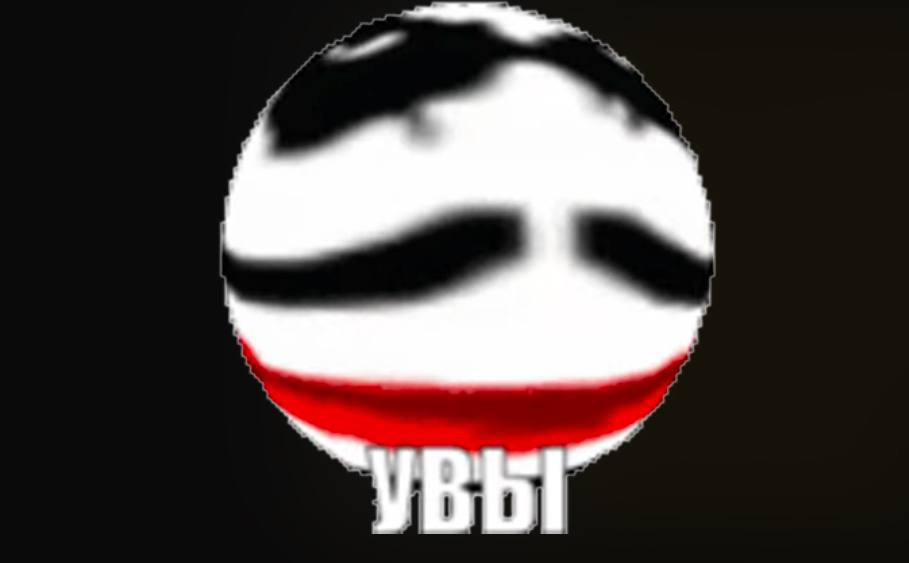


**Программист пишет другу:**

**— Я настроил тебе доступ к API ChatGPT. Вот, высылаю ключи, документацию и… гвозди.**

**— Гвозди зачем?**

**— Ну как зачем, ключи вставишь, документацию почитаешь и… пойдёшь чинить, если не заработает!**

In [41]:
from transformers import AutoTokenizer, GenerationConfig, AutoModelForCausalLM, AutoConfig

model_name = 'Qwen/Qwen2.5-7B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0", 
                                             attn_implementation="flash_attention_2")
model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm

In [88]:
import torch
import numpy as np
from transformers import GenerationConfig

def classify_sequence_qwen(test_sentence, model, tokenizer):
    few_shot_examples = """
    The format:
    Input: "<sentence>"
    Output: "<NER tags>"

    Examples:
    Input: "eu rejects german call to boycott british lamb ."
    Output: "B-ORG O B-MISC O O O B-MISC O O"

    Input: "peter blackburn"
    Output: "B-PER I-PER"
    
    Input: "soccer - japan get lucky win , china in surprise defeat ."
    Output: "O O B-LOC O O O O B-PER O O O O"

    Input: "al-ain , united arab emirates 1996-12-06"
    Output: "B-LOC O B-LOC I-LOC I-LOC O"
    
    Input: "the european commission said on thursday it disagreed with german advice to consumers to shun british lamb until scientists determine whether mad cow disease can be transmitted to sheep ."
    Output: "O B-ORG I-ORG O O O O O O B-MISC O O O O O B-MISC O O O O O O O O O O O O O O"
    """

    prompt = f"""
    You are an expert in NER tagging. Here are some examples of how NER tagging should be done:\n
    {few_shot_examples}\n Please classify the following sentence with the following categories:
    'O','B-LOC','B-MISC','B-ORG','B-PER','I-LOC','I-MISC','I-ORG','I-PER' \nInput: \"{test_sentence}\"\nOutput:"""
    
    generation_config = GenerationConfig.from_pretrained(model_name)
    generation_config.max_new_tokens = 128
    generation_config.temperature = 0.1

    inputs = tokenizer.apply_chat_template([
        {'role': 'user', 'content': prompt}
    ], add_generation_prompt=True, tokenize=True, return_tensors='pt')
    
    input_ids = inputs.to(model.device)

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    output = model.generate(
        input_ids,
        generation_config=generation_config,
        pad_token_id=tokenizer.pad_token_id  
    )[:, input_ids.shape[-1]:].detach().cpu()

    output_text = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return output_text.strip()

In [89]:
test_token_seq_qwen = test_token_seq[:30]
predictions = []

for sentence in test_token_seq_qwen:
    ner_tags = classify_sequence_qwen(' '.join(sentence), model, tokenizer)
    predictions.append(ner_tags.split())

In [ ]:
def clean_ner_tags(data):
    valid_tags = {'O', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER'}
    cleaned_data = []

    for sublist in data:
        cleaned_sublist = []
        for item in sublist:
            cleaned_item = item.strip('"')
            if cleaned_item in valid_tags:
                cleaned_sublist.append(cleaned_item)
        cleaned_data.append(cleaned_sublist)
    
    return cleaned_data

In [90]:
cleaned_predictions = clean_ner_tags(predictions)

In [87]:
labels = test_label_seq[:30]
labels

[['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O'],
 ['B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'I-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O'],
 ['B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MISC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  

In [95]:
def align_predictions_and_labels(predictions: List[List[str]], labels: List[List[str]]) -> (List[List[str]], List[List[str]]):
    aligned_predictions = []
    aligned_labels = []

    for pred, label in zip(predictions, labels):
        if len(pred) > len(label):
            aligned_predictions.append(pred[:len(label)])
            aligned_labels.append(label)
        elif len(pred) < len(label):
            aligned_predictions.append(pred + ["O"] * (len(label) - len(pred)))
            aligned_labels.append(label)
        else:
            aligned_predictions.append(pred)
            aligned_labels.append(label)

    return aligned_predictions, aligned_labels


def compute_f1_macro(predictions: List[List[str]], labels: List[List[str]]) -> float:
    predictions, labels = align_predictions_and_labels(predictions, labels)
    
    f1_scores = []
    for pred, label in zip(predictions, labels):
        f1 = f1_score(label, pred, average='macro', zero_division=0)
        f1_scores.append(f1)
    
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0.0

In [96]:
f1_macro = compute_f1_macro(cleaned_predictions, labels)
f1_macro

0.5743655783589628

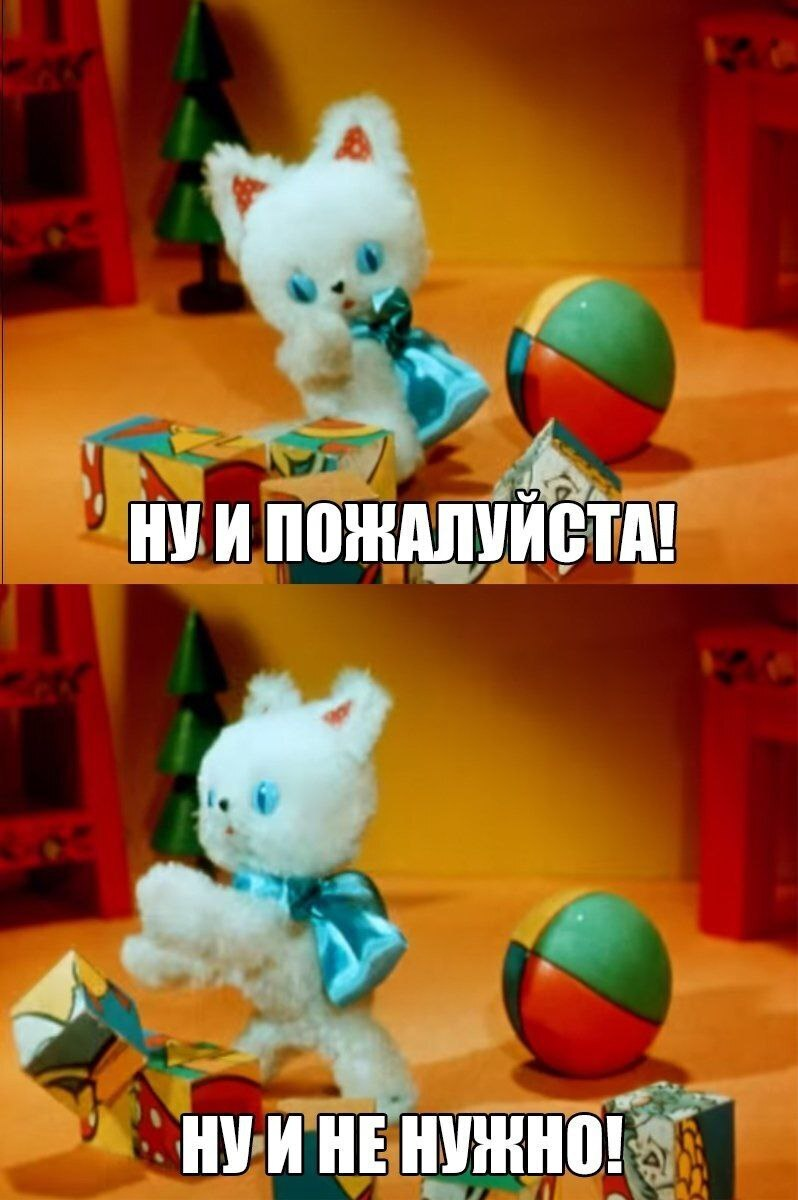